In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34147,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:34719,Total threads: 4
Dashboard: /proxy/45481/status,Memory: 143.87 GiB
Nanny: tcp://127.0.0.1:46357,


In [3]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [4]:
# Average U_along into mean, seasonal, monthly and annual fields

u_along_da_mean = u_along.mean('time').u_along_contour_binned
u_along_da_seasonal = u_along.groupby('time.month').mean('time').u_along_contour_binned
u_along_da_annual = u_along.groupby('time.year').mean('time').u_along_contour_binned
## CHECK: Is this the right way? 
u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned

u_along_da_mean.load()
u_along_da_seasonal.load()
u_along_da_annual.load()
u_along_da_monthly.load()

<xarray.DataArray 'u_along_contour_binned' (time: 732, st_ocean: 75,
                                            lon_bin_midpoints: 1428)> Size: 627MB
array([[[-0.02359511, -0.02475564, -0.02657239, ..., -0.0204653 ,
         -0.02053152, -0.02350026],
        [-0.01865366, -0.01979311, -0.02162974, ..., -0.01303114,
         -0.01375674, -0.01694079],
        [-0.01603528, -0.01716227, -0.01901062, ..., -0.00900011,
         -0.0100713 , -0.01337444],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.06889385, -0.06873107, -0.06851074, ..., -0.02077237,
         -0.02169113, -0.02693162],
        [-0.06278588, -0.06240495, -0.06204439, ..., -0.01473967,
         -0.01655271, -0.02205193],
        [-0.05906674, -0.05856833, -0.05814252, ..., -0.01109173,
         -0.01338399, -0.0190114 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.0376156 , -0.03683981, -0.03611625, ..., -0.03758969,
         -0.03398371, -0.03630787],
        [-0.03121829, -0.0303874 , -0.02965705, ..., -0.0294911 ,
         -0.02702347, -0.02966545],
        [-0.02686711, -0.02600385, -0.02527127, ..., -0.02429345,
         -0.0225731 , -0.02540491],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * st_ocean           (st_ocean) float64 600B 0.5413 1.681 ... 5.709e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25
  * time               (time) datetime64[ns] 6kB 1958-01-31 ... 2018-12-31

(50, 1428)


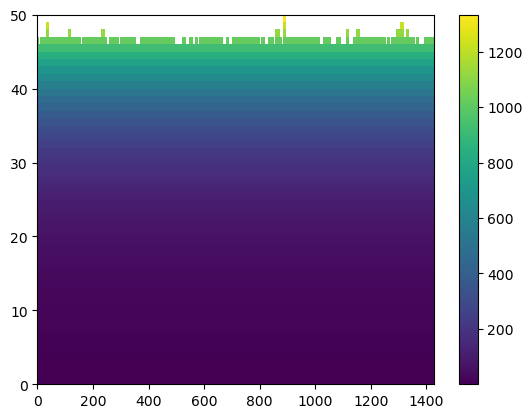

In [5]:
# save depth coordinate to use in the last plot

depthT = u_along_da_mean.st_ocean
depthT = depthT.expand_dims(dim={'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints.size},axis=1)\
.assign_coords({'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints})
depthT = (depthT*u_along_da_mean/u_along_da_mean).rename('depth')
# remove last 25 layers
depthT=depthT[0:50,:]

plt.pcolormesh(depthT)
plt.colorbar()

print(depthT.shape)

In [6]:
## GMM doesn't accept any NaNs - so, we need to drop all NaNs in depth space and normalise onto a sigma co-ordinate (between 0 and 1)
depths_2d_da = u_along_da_mean.st_ocean
depths_2d_da = depths_2d_da.expand_dims(dim={'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints.size},axis=1)\
.assign_coords({'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints})
depths_2d_da = (depths_2d_da*u_along_da_mean/u_along_da_mean).rename('depth')

# Calculate the values of M and O, the columns and rows of U_along
n_rows = u_along_da_mean.shape[0]
o_cols = u_along_da_mean.shape[1]
m_rows = n_rows // o_cols

reshaped_u_along_df_season = []
reshaped_u_along_df_annual = []
reshaped_u_along_df_monthly = []

# Reshape the DataFrame to an MxO shape, and drop NaNs from the depth axis
reshaped_u_along_df = pd.DataFrame(np.array(u_along_da_mean).reshape(n_rows, o_cols), index=u_along_da_mean.st_ocean, columns=u_along_da_mean.lon_bin_midpoints)
reshaped_u_along_df = reshaped_u_along_df.dropna(how='all', axis=0)
for i in tqdm(range(12)):
    tmp = (pd.DataFrame(np.array(u_along_da_seasonal)[i,:,:].reshape(n_rows, o_cols), index=u_along_da_seasonal.st_ocean, columns=u_along_da_seasonal.lon_bin_midpoints))
    reshaped_u_along_df_season.append(tmp.dropna(how='all', axis=0))
for i in tqdm(range(u_along_da_annual.year.size)):
    tmp = (pd.DataFrame(np.array(u_along_da_annual)[i,:,:].reshape(n_rows, o_cols), index=u_along_da_annual.st_ocean, columns=u_along_da_annual.lon_bin_midpoints))
    reshaped_u_along_df_annual.append(tmp.dropna(how='all', axis=0))
for i in tqdm(range(u_along_da_monthly.time.size)):
    tmp = (pd.DataFrame(np.array(u_along_da_monthly)[i,:,:].reshape(n_rows, o_cols), index=u_along_da_monthly.st_ocean, columns=u_along_da_monthly.lon_bin_midpoints))
    reshaped_u_along_df_monthly.append(tmp.dropna(how='all', axis=0))

## Do the same for the depth array
reshaped_depths_df = pd.DataFrame(np.array(depths_2d_da).reshape(n_rows, o_cols), index=u_along_da_mean.st_ocean, columns=u_along_da_mean.lon_bin_midpoints)
reshaped_depths_df = reshaped_depths_df.dropna(how='all', axis=0)

100%|██████████| 732/732 [03:03<00:00,  4.00it/s]


In [7]:
## Create sigma bins for interpolation
normalised_depths_df = reshaped_depths_df/reshaped_depths_df.max(skipna=True, axis=0)
depth_bins = reshaped_depths_df.index/reshaped_depths_df.index[-1]

In [8]:
%%time
## Interpolate onto a uniform [0,1] sigma co-ordinate for all profiles
import scipy.interpolate as interpolate

new_u_along = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
new_u_along_season = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
new_u_along_season_list = []
new_u_along_annual = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
new_u_along_annual_list = []
new_u_along_monthly = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
new_u_along_monthly_list = []

for i in tqdm(range(normalised_depths_df.keys().size)):
        f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df[normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
        new_u_along[:,i] = f_values_u_along(depth_bins)

for j in tqdm(range(12)):
    new_u_along_season = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
    for i in (range(normalised_depths_df.keys().size)):
        f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df_season[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
        new_u_along_season[:,i] = f_values_u_along(depth_bins)
    new_u_along_season_list.append(new_u_along_season)

for j in tqdm(range(u_along_da_annual.year.size)):
    new_u_along_annual = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
    for i in (range(normalised_depths_df.keys().size)):
        f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df_annual[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
        new_u_along_annual[:,i] = f_values_u_along(depth_bins)
    new_u_along_annual_list.append(new_u_along_annual)

for j in tqdm(range(u_along_da_monthly.time.size)):
    new_u_along_monthly = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
    for i in (range(normalised_depths_df.keys().size)):
        f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df_monthly[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
        new_u_along_monthly[:,i] = f_values_u_along(depth_bins)
    new_u_along_monthly_list.append(new_u_along_monthly)

100%|██████████| 732/732 [03:18<00:00,  3.69it/s]

CPU times: user 3min 44s, sys: 34.4 s, total: 4min 18s
Wall time: 3min 39s


In [9]:
## Define the dataframe that will be fed into the GMM -  we are dropping NaNs
new_u_along_df = pd.DataFrame(new_u_along, index=depth_bins, columns=normalised_depths_df.keys())
new_u_along_df = new_u_along_df.dropna(how='all', axis=1)

new_u_along_df_season = []
new_u_along_df_annual = []
new_u_along_df_monthly = []

for j in tqdm(range(12)):
    tmp = pd.DataFrame(new_u_along_season_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_u_along_df_season.append(tmp.dropna(how='all', axis=1))

for j in tqdm(range(u_along_da_annual.year.size)):
    tmp = pd.DataFrame(new_u_along_annual_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_u_along_df_annual.append(tmp.dropna(how='all', axis=1))

for j in tqdm(range(u_along_da_monthly.time.size)):
    tmp = pd.DataFrame(new_u_along_monthly_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_u_along_df_monthly.append(tmp.dropna(how='all', axis=1))

100%|██████████| 732/732 [00:00<00:00, 963.49it/s]


In [10]:
# Convert into DataArrays
u_along_da = xr.DataArray(new_u_along_df.values, \
                              coords={'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')
u_along_da_seasons = xr.DataArray(np.array(new_u_along_df_season), coords={'month':u_along_da_seasonal.month.values, 'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'month':u_along_da_seasonal.month.size,'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')
u_along_da_yearly = xr.DataArray(np.array(new_u_along_df_annual), coords={'year':u_along_da_annual.year.values, 'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'year':u_along_da_annual.year.size,'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')
u_along_da_months = xr.DataArray(np.array(new_u_along_df_monthly), coords={'time':u_along_da_monthly.time.values, 'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'time':u_along_da_monthly.time.size,'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')

In [11]:
# Define the surface, depth u_along that will be fed into the GMM
surf_u_along_da = u_along_da.sel(depth=slice(0,0.3))
deep_u_along_da = u_along_da.sel(depth=slice(0.3, None))

surf_u_along_da_seasons = u_along_da_seasons.sel(depth=slice(0,0.3))
deep_u_along_da_seasons = u_along_da_seasons.sel(depth=slice(0.3, None))

surf_u_along_da_annual = u_along_da_yearly.sel(depth=slice(0,0.3))
deep_u_along_da_annual = u_along_da_yearly.sel(depth=slice(0.3, None))

surf_u_along_da_months = u_along_da_months.sel(depth=slice(0,0.3))
deep_u_along_da_months = u_along_da_months.sel(depth=slice(0.3, None))

## CHECK: Note the depth-averaging below is NOT weighted - as it turns out this doesn't 
## make a difference to the regime definitions

surf_u_along_da_avg = surf_u_along_da.mean('depth')
deep_u_along_da_avg = deep_u_along_da.mean('depth')

surf_u_along_da_seasons_avg = surf_u_along_da_seasons.mean('depth')
deep_u_along_da_seasons_avg = deep_u_along_da_seasons.mean('depth')

surf_u_along_da_annual_avg = surf_u_along_da_annual.mean('depth')
deep_u_along_da_annual_avg = deep_u_along_da_annual.mean('depth')

surf_u_along_da_months_avg = surf_u_along_da_months.mean('depth')
deep_u_along_da_months_avg = deep_u_along_da_months.mean('depth')

## 'result' is the array that is fed into GMM

result_mean = xr.concat([(surf_u_along_da_avg/surf_u_along_da_avg.std()-deep_u_along_da_avg/deep_u_along_da_avg.std()),\
                     ((u_along_da/abs(u_along_da)).isel(depth=0))\
                         /((u_along_da/abs(u_along_da)).isel(depth=0)).std()], dim='loc')
result_seasons = xr.concat([(surf_u_along_da_seasons_avg/surf_u_along_da_seasons_avg.std()-deep_u_along_da_seasons_avg/deep_u_along_da_seasons_avg.std()),\
                     ((u_along_da_seasons/abs(u_along_da_seasons)).isel(depth=0))\
                            /((u_along_da_seasons/abs(u_along_da_seasons)).isel(depth=0)).std()], dim='loc')
result_annual = xr.concat([(surf_u_along_da_annual_avg/surf_u_along_da_annual_avg.std()-deep_u_along_da_annual_avg/deep_u_along_da_annual_avg.std()),\
                     ((u_along_da_yearly/abs(u_along_da_yearly)).isel(depth=0))\
                            /((u_along_da_yearly/abs(u_along_da_yearly)).isel(depth=0)).std()], dim='loc')
result_months = xr.concat([(surf_u_along_da_months_avg/surf_u_along_da_months_avg.std()-deep_u_along_da_months_avg/deep_u_along_da_months_avg.std()),\
                     ((u_along_da_months/abs(u_along_da_months)).isel(depth=0))\
                            /((u_along_da_months/abs(u_along_da_months)).isel(depth=0)).std()], dim='loc')



In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

n_clusters = []
labels_gmm = []
centers_gmm = []
probs_gmm = []

aic_gmm = []
bic_gmm = []
silhouette_gmm = []

X = result_mean.T

k_clusters = range(1,22)
# We are varying number of clusters to see which is optimal using some diagnostics like AIC, BIC etc. 
for k in tqdm(k_clusters):
    n_clusters.append(k)
    # This is the GMM model definition
    gmm = GaussianMixture(n_components=k, random_state=42)
    # Labels is the actual mask that is produced
    labels_gmm.append(gmm.fit_predict(X))
    centers_gmm.append(gmm.means_)
    probs_gmm.append(gmm.predict_proba(X))
    aic_gmm.append(gmm.aic(X))
    bic_gmm.append(gmm.bic(X))
    if k>=3:
        silhouette_gmm.append(silhouette_score(X, labels_gmm[k-2], metric='euclidean'))


100%|██████████| 21/21 [00:01<00:00, 19.46it/s]


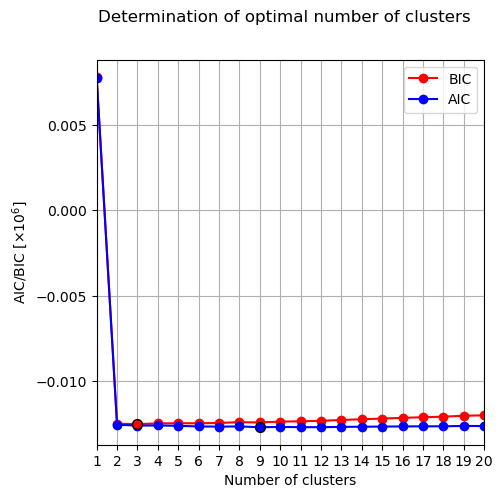

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# axs = axs.ravel()
plt.subplots_adjust(hspace = 0.3, wspace=0.3)

axs.plot(n_clusters, np.array(bic_gmm)/10**6, 'r-o', label='BIC')
axs.plot(n_clusters, np.array(aic_gmm)/10**6, 'b-o', label='AIC')
axs.scatter(n_clusters[np.argmin(aic_gmm)], aic_gmm[np.argmin(aic_gmm)]/10**6, 50, color='blue', ec='k', zorder=10000)
axs.scatter(n_clusters[np.argmin(bic_gmm)], bic_gmm[np.argmin(bic_gmm)]/10**6, 50, color='red', ec='k', zorder=10000)

axs.set_xticks(n_clusters)
axs.set_xlabel('Number of clusters')
axs.set_xlim(1,20)
axs.grid()
axs.set_ylabel(r'AIC/BIC [$\times10^6$]')
axs.legend()

plt.suptitle('Determination of optimal number of clusters', fontsize=12)
plt.show()

In [14]:
# Note: Optimal n is 1 less than the actual number of clusters, so n_optimal = 2 implies 3 clusters, etc. 
n_optimal = 2

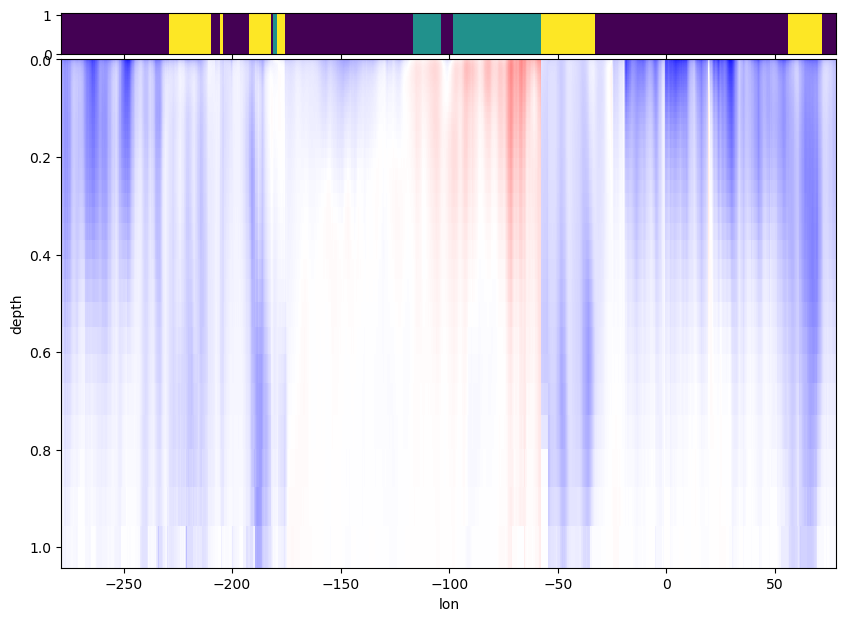

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.02, wspace=0.02)

axs[0].pcolor(u_along_da_mean.lon_bin_midpoints.values , depth_bins, np.repeat(labels_gmm[n_optimal][:,np.newaxis], depth_bins.size, axis=-1).T)
u_along_da.plot(ax=axs[1], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
axs[1].invert_yaxis()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
labels_gmm_seasons = []
for i in tqdm(range(12)):
    Y = result_seasons.isel(month=i).T
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels_gmm_seasons.append(gmm.fit(X).predict(Y))

100%|██████████| 12/12 [00:00<00:00, 102.49it/s]


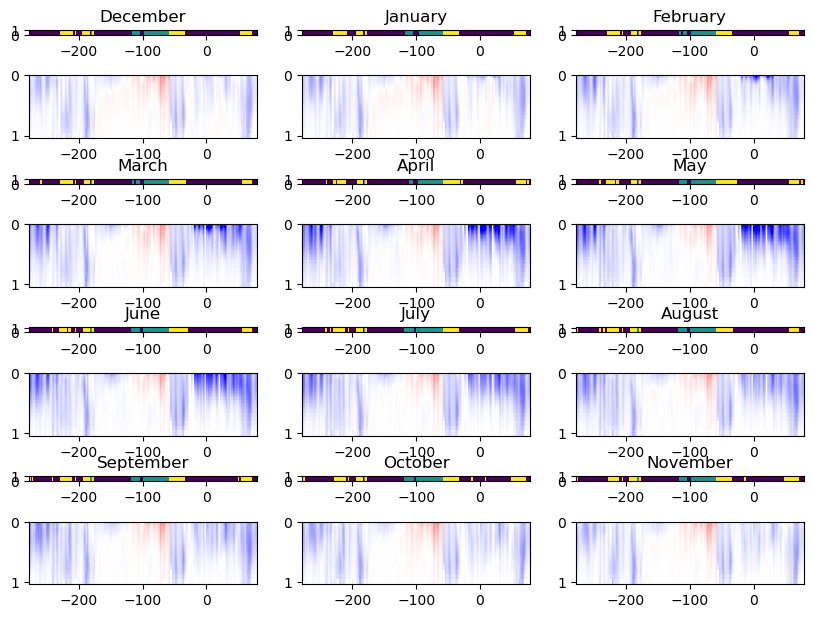

In [17]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1,0.08,1,0.08,1,0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 1.2, wspace=0.2)

label_inds = [0,1,2,6,7,8,12,13,14,18,19,20]
vel_inds = [3,4,5,9,10,11,15,16,17,21,22,23]
seasons_inds = [11,0,1,2,3,4,5,6,7,8,9,10]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for j in range(12):
    axs[label_inds[j]].pcolor(u_along_da_mean.lon_bin_midpoints.values , depth_bins, np.repeat(labels_gmm_seasons[seasons_inds[j]][:,np.newaxis], depth_bins.size, axis=-1).T)
    u_along_da_seasons.isel(month=seasons_inds[j]).plot(ax=axs[vel_inds[j]], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
    axs[vel_inds[j]].invert_yaxis()
    axs[label_inds[j]].set_title(months[seasons_inds[j]])
    axs[vel_inds[j]].set_title('')
    axs[vel_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_xlabel('')
    axs[vel_inds[j]].set_xlabel('')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_seasons.png', dpi=300, bbox_inches='tight')
plt.show()

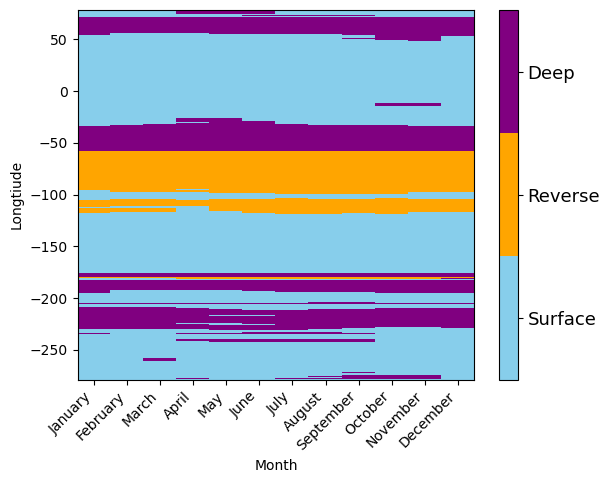

In [18]:
colors = ['skyblue', 'orange', 'purple']
values = [0, 1, 2]
classes = ['Surface', 'Reverse', 'Deep']
cmap = plt.cm.colors.ListedColormap(colors)

plt.pcolor(months,  u_along_da_mean.lon_bin_midpoints.values, np.array(labels_gmm_seasons).T, cmap=cmap)
plt.gca().set_xticklabels(months, rotation=45, ha='right')
cbar = plt.colorbar()
# cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_yticks([1/3,1,5/3])
cbar.ax.set_yticklabels(classes)
plt.ylabel('Longtiude')
plt.xlabel('Month')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_season_labels.png', dpi=300, bbox_inches='tight')
plt.show()

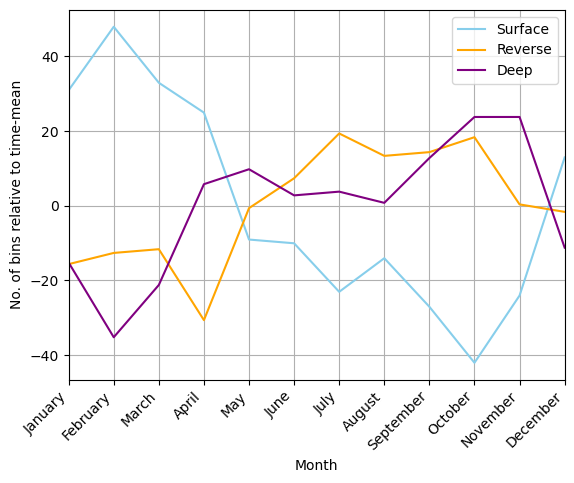

In [19]:
cnt_szn = np.zeros((3,12))
for j in range(3):
    for i in range(12):
        cnt_szn[j,i] = labels_gmm_seasons[i].tolist().count(j)

    plt.plot(cnt_szn[j,:]-np.nanmean(cnt_szn[j,:]), c = colors[j], label = classes[j])
plt.gca().set_xticks(np.arange(0,12))
plt.gca().set_xticklabels(months, rotation=45, ha='right')
plt.legend()
plt.grid()
plt.ylabel('No. of bins relative to time-mean')
plt.xlabel('Month')
plt.xlim(0,11)
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/labels_dist_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
labels_gmm_annual = []
for i in tqdm(range(u_along_da_yearly.year.size)):
    Y = result_annual.isel(year=i).T
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels_gmm_annual.append(gmm.fit(X).predict(Y))

100%|██████████| 61/61 [00:00<00:00, 102.19it/s]


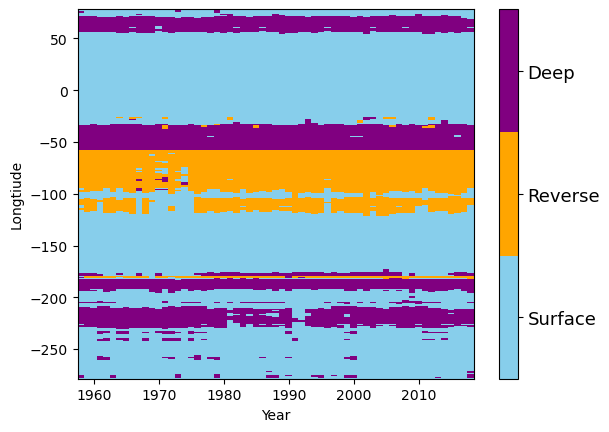

In [21]:
plt.pcolor(u_along_da_annual.year,  u_along_da_mean.lon_bin_midpoints.values, np.array(labels_gmm_annual).T, cmap=cmap)
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
cbar = plt.colorbar()
# cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_yticks([1/3,1,5/3])
cbar.ax.set_yticklabels(classes)
plt.ylabel('Longtiude')
plt.xlabel('Year')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_annual_labels.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 61/61 [00:00<00:00, 44135.34it/s]


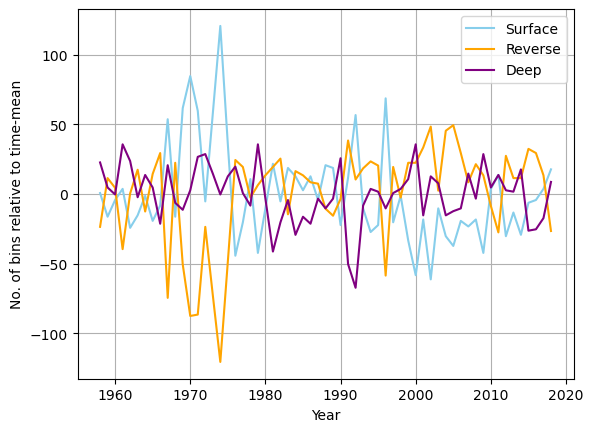

In [22]:
cnt_anno = np.zeros((3,u_along_da_yearly.year.size))
for j in range(3):
    for i in tqdm(range(u_along_da_yearly.year.size)):
        cnt_anno[j,i] = labels_gmm_annual[i].tolist().count(j)

    plt.plot(u_along_da_yearly.year, cnt_anno[j,:]-np.nanmean(cnt_anno[j,:]), c = colors[j], label = classes[j])
# plt.gca().set_xticks(np.arange(0,12))
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
plt.legend()
plt.grid()
plt.ylabel('No. of bins relative to time-mean')
plt.xlabel('Year')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/labels_dist_annual.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
labels_gmm_months = []
for i in tqdm(range(u_along_da_monthly.time.size)):
    Y = result_months.isel(time=i).T
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels_gmm_months.append(gmm.fit(X).predict(Y))

100%|██████████| 732/732 [00:07<00:00, 100.66it/s]


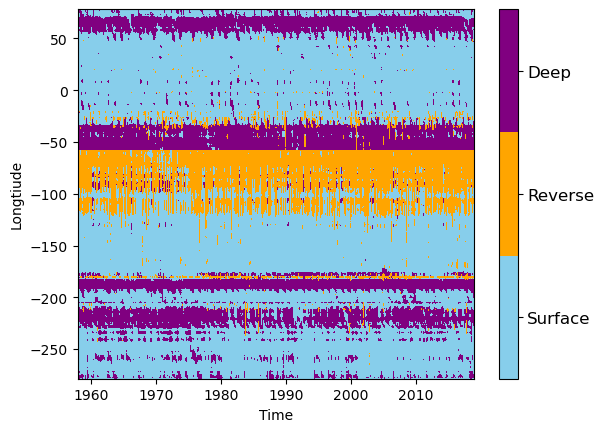

In [24]:
plt.pcolor(np.arange(u_along_da_months.time.size)/12+1958,  u_along_da_mean.lon_bin_midpoints.values, np.array(labels_gmm_months).T, cmap=cmap)
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
cbar = plt.colorbar()
# cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticks([1/3,1,5/3])
cbar.ax.set_yticklabels(classes)
plt.ylabel('Longtiude')
plt.xlabel('Time')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_monthly_labels.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 732/732 [00:00<00:00, 43795.37it/s]


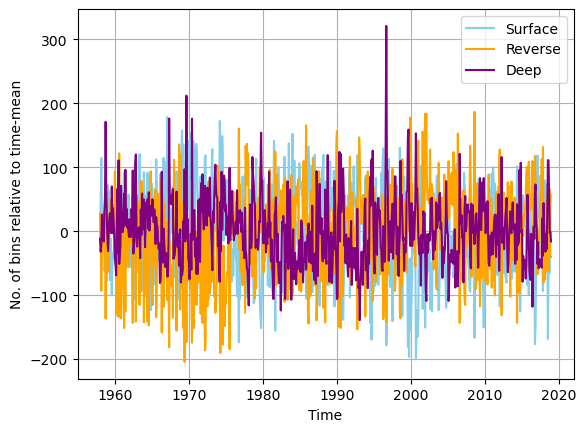

In [25]:
cnt_monthly = np.zeros((3,u_along_da_monthly.time.size))
for j in range(3):
    for i in tqdm(range(u_along_da_monthly.time.size)):
        cnt_monthly[j,i] = labels_gmm_months[i].tolist().count(j)

    plt.plot(np.arange(u_along_da_months.time.size)/12+1958, cnt_monthly[j,:]-np.nanmean(cnt_monthly[j,:]), c = colors[j], label = classes[j])
# plt.gca().set_xticks(np.arange(0,12))
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
plt.legend()
plt.grid()
plt.ylabel('No. of bins relative to time-mean')
plt.xlabel('Time')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/labels_dist_monthly.png', dpi=300, bbox_inches='tight')
plt.show()

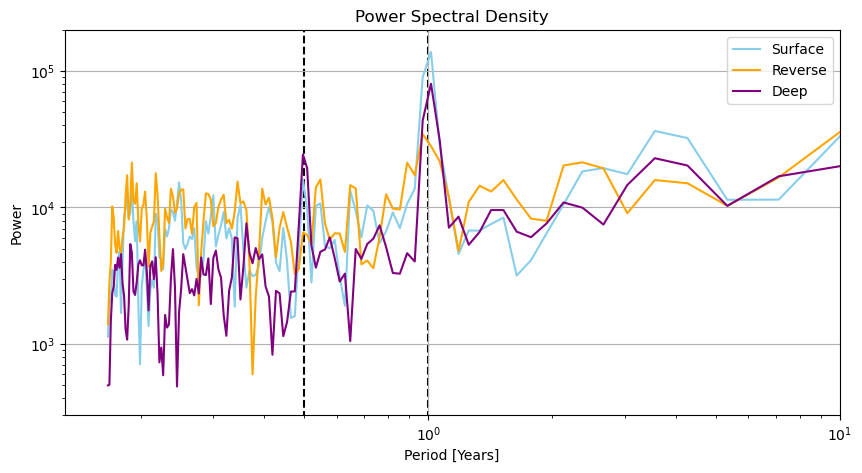

In [26]:
from scipy import signal
# Plot the power spectral density
plt.figure(figsize=(10, 5))

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(cnt_monthly[j,:], fs=1)
    plt.loglog(1/frequencies/12, psd, c = colors[j], label = classes[j])

plt.title('Power Spectral Density')
plt.vlines(0.5,1e2,1e6, color='black', linestyle='dashed', zorder=-1)
plt.vlines(1,1e2,1e6, color='black', linestyle='dashed', zorder=-1)

plt.ylim(3e2,2e5)
plt.xlabel('Period [Years]')
plt.ylabel('Power')
plt.xlim(0,10)
plt.grid()
plt.legend()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/monthly_power_spectra.png', dpi=300, bbox_inches='tight')
plt.show()

## Divided along contour into longitudinal bins:

In [27]:
# get time-mean regimes mask

ds = xr.open_dataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
regime_mask = ds.regimes_mask
ds.close()
regime_mask.load()

<xarray.DataArray 'regimes_mask' (regime: 3, lon: 1428)> Size: 34kB
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * regime   (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon      (lon) float64 11kB -278.5 -278.2 -278.0 -277.8 ... 77.75 78.0 78.25

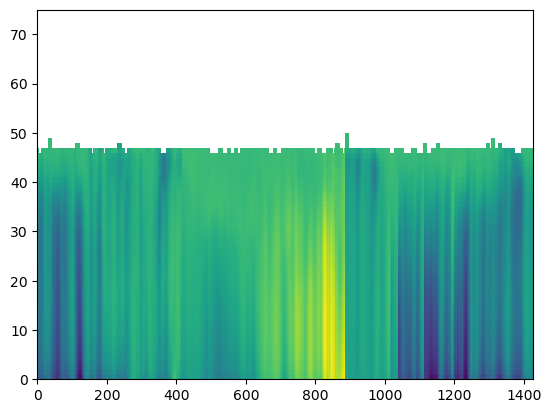

In [28]:
plt.pcolormesh(u_along_da_mean)

In [29]:
# # first rename u_along_da_mean/u_along_da_annuak longitude dimension
# # from "lon_bin_midpoints" to "lon" (to match masks)

u_along_da_mean = u_along_da_mean.rename({'lon_bin_midpoints': 'lon'})
u_along_da_annual = u_along_da_annual.rename({'lon_bin_midpoints': 'lon'})


In [30]:
# annual avg whole IAF
u_along_da_mean_masked = u_along_da_mean.expand_dims(dim={"regime": 3})
u_along_da_mean_masked = u_along_da_mean_masked*regime_mask
# monthly climatology 
u_along_da_seasons_masked = u_along_da_seasons.expand_dims(dim={"regime": 3})
u_along_da_seasons_masked = u_along_da_seasons_masked*regime_mask
# monthly avg yearly IAF
u_along_da_months_masked = u_along_da_months.expand_dims(dim={"regime": 3})
u_along_da_months_masked = u_along_da_months_masked*regime_mask
# annual avg yearly IAF
u_along_da_annual_masked = u_along_da_annual.expand_dims(dim={"regime": 3})
u_along_da_annual_masked = u_along_da_annual_masked*regime_mask

Fabio: the code below is for calculating the statistics for different longitudinal bin's sizes; I have already done this and saved the outputs.
The netcdf contain these statistics are in: /g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/



### first doing it for 5deg longitude bins:

In [32]:
# Define bin edges for 5-degree bins
lon_bin=5
# defined 'bin_edges'
bin_edges = np.arange(u_along_da_seasons_masked.lon[0], u_along_da_seasons_masked.lon[-1], lon_bin)

# Group longitudes into 5-degree bins
ds = u_along_da_mean_masked
u_along_da_mean_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_seasons_masked
u_along_da_seasons_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_months_masked
u_along_da_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_annual_masked
u_along_da_annual_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

#load 
u_along_da_mean_binned.load()
u_along_da_seasons_binned.load()
u_along_da_months_binned.load()
u_along_da_annual_binned.load()

<xarray.DataArray (regime: 3, year: 61, st_ocean: 75, lon_bins: 71)> Size: 8MB
array([[[[-0.14103416, -0.13426226, -0.1990108 , ...,         nan,
                  nan, -0.09104749],
         [-0.12793666, -0.12006745, -0.18831344, ...,         nan,
                  nan, -0.07921173],
         [-0.12087733, -0.11205782, -0.18214691, ...,         nan,
                  nan, -0.07254972],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[-0.13071278, -0.11036583, -0.17086287, ...,         nan,
                  nan, -0.0894572 ],
         [-0.11721137, -0.09553825, -0.16015286, ...,         nan,
                  nan, -0.0779984 ],
         [-0.11000579, -0.08729582, -0.15407291, ...,         nan,
                  nan, -0.07144961],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ..., -0.18903834,
          -0.20194549, -0.12177145],
         [        nan,         nan,         nan, ..., -0.17110927,
          -0.1894172 , -0.11325091],
         [        nan,         nan,         nan, ..., -0.16121677,
          -0.18202252, -0.10796268],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * year      (year) int64 488B 1958 1959 1960 1961 1962 ... 2015 2016 2017 2018
  * regime    (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bins  (lon_bins) object 568B (-278.5, -273.5] ... (71.5, 76.5]

In [33]:
# Group longitudes into 5-degree bins for depth array"
ds = depthT
depthT_binned = ds.groupby_bins('lon_bin_midpoints', bins=bin_edges).mean()
print(ds)


<xarray.DataArray 'depth' (st_ocean: 50, lon_bin_midpoints: 1428)> Size: 571kB
array([[0.54128075, 0.54128075, 0.54128075, ..., 0.54128075, 0.54128075,
        0.54128075],
       [1.68073463, 1.68073463, 1.68073463, ..., 1.68073463, 1.68073463,
        1.68073463],
       [2.93995261, 2.93995261, 2.93995261, ..., 2.93995261, 2.93995261,
        2.93995261],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * st_ocean           (st_ocean) float64 400B 0.5413 1.681 ... 1.333e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25


#### ploting some figures of U_along to check if binning has gone well:

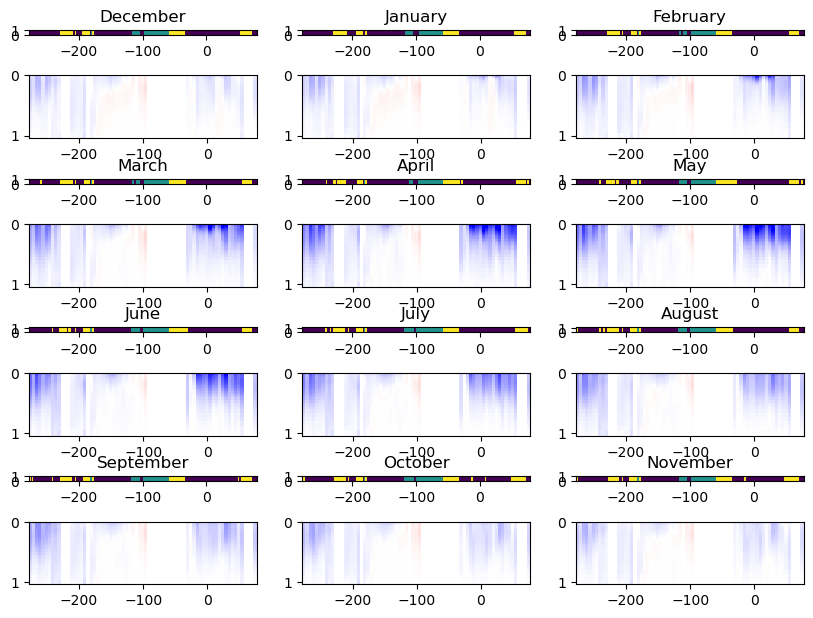

In [34]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1,0.08,1,0.08,1,0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 1.2, wspace=0.2)

label_inds = [0,1,2,6,7,8,12,13,14,18,19,20]
vel_inds = [3,4,5,9,10,11,15,16,17,21,22,23]
seasons_inds = [11,0,1,2,3,4,5,6,7,8,9,10]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for j in range(12):
    axs[label_inds[j]].pcolor(u_along_da_seasons.lon, depth_bins, np.repeat(labels_gmm_seasons[seasons_inds[j]][:,np.newaxis], depth_bins.size, axis=-1).T)
    u_along_da_seasons_binned.isel(regime=0,month=seasons_inds[j]).plot(ax=axs[vel_inds[j]], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
    axs[vel_inds[j]].invert_yaxis()
    axs[label_inds[j]].set_title(months[seasons_inds[j]])
    axs[vel_inds[j]].set_title('')
    axs[vel_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_xlabel('')
    axs[vel_inds[j]].set_xlabel('')
plt.savefig('/g/data/hh5/tmp/access-om/fbd581/ASC_project/ASC_and_heat_transport/figs/GMM_ASC_trained_seasons_5degBins_v2_surface.png', dpi=300, bbox_inches='tight')
plt.show()

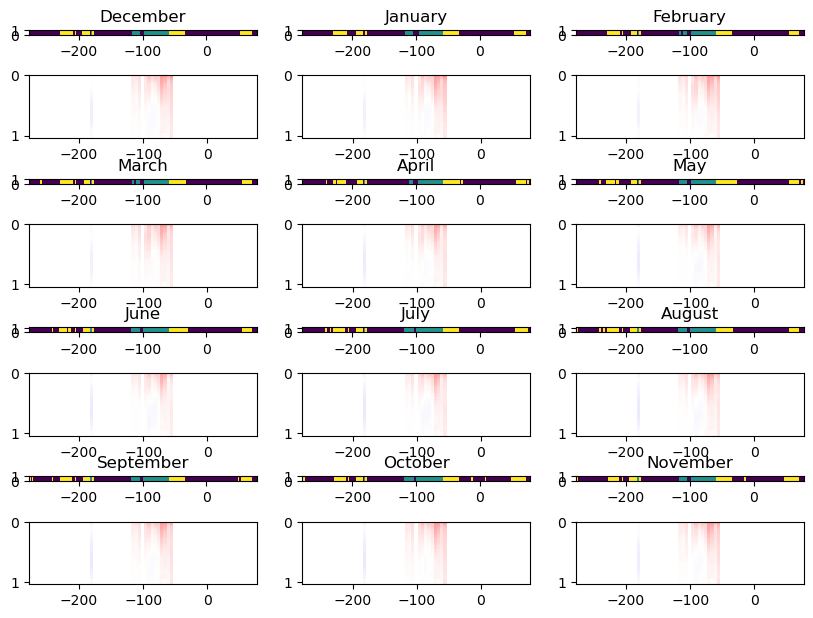

In [35]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1,0.08,1,0.08,1,0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 1.2, wspace=0.2)

label_inds = [0,1,2,6,7,8,12,13,14,18,19,20]
vel_inds = [3,4,5,9,10,11,15,16,17,21,22,23]
seasons_inds = [11,0,1,2,3,4,5,6,7,8,9,10]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for j in range(12):
    axs[label_inds[j]].pcolor(u_along_da_seasons.lon, depth_bins, np.repeat(labels_gmm_seasons[seasons_inds[j]][:,np.newaxis], depth_bins.size, axis=-1).T)
    u_along_da_seasons_binned.isel(regime=1,month=seasons_inds[j]).plot(ax=axs[vel_inds[j]], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
    axs[vel_inds[j]].invert_yaxis()
    axs[label_inds[j]].set_title(months[seasons_inds[j]])
    axs[vel_inds[j]].set_title('')
    axs[vel_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_xlabel('')
    axs[vel_inds[j]].set_xlabel('')
plt.savefig('/g/data/hh5/tmp/access-om/fbd581/ASC_project/ASC_and_heat_transport/figs/GMM_ASC_trained_seasons_5degBins_v2_reverse.png', dpi=300, bbox_inches='tight')
plt.show()

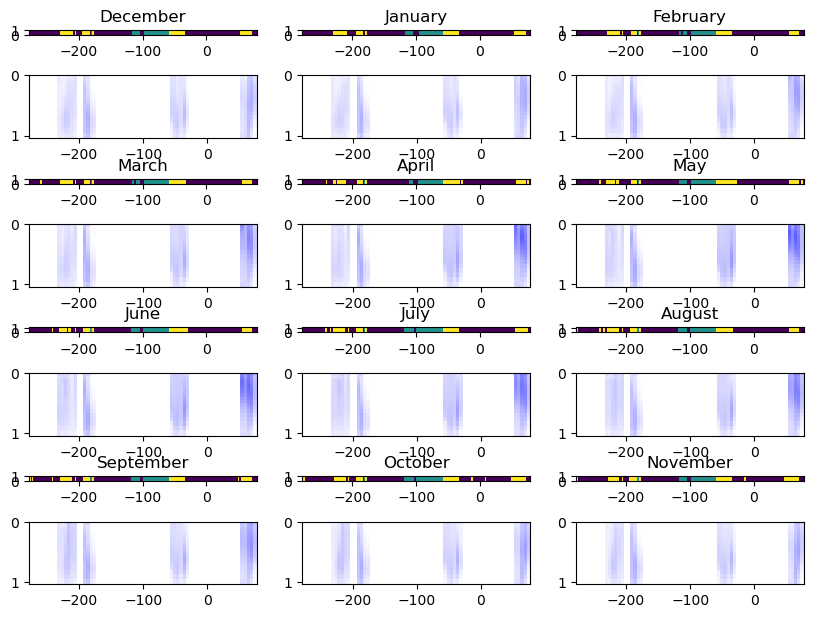

In [36]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1,0.08,1,0.08,1,0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 1.2, wspace=0.2)

label_inds = [0,1,2,6,7,8,12,13,14,18,19,20]
vel_inds = [3,4,5,9,10,11,15,16,17,21,22,23]
seasons_inds = [11,0,1,2,3,4,5,6,7,8,9,10]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for j in range(12):
    axs[label_inds[j]].pcolor(u_along_da_seasons.lon, depth_bins, np.repeat(labels_gmm_seasons[seasons_inds[j]][:,np.newaxis], depth_bins.size, axis=-1).T)
    u_along_da_seasons_binned.isel(regime=2,month=seasons_inds[j]).plot(ax=axs[vel_inds[j]], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
    axs[vel_inds[j]].invert_yaxis()
    axs[label_inds[j]].set_title(months[seasons_inds[j]])
    axs[vel_inds[j]].set_title('')
    axs[vel_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_xlabel('')
    axs[vel_inds[j]].set_xlabel('')
plt.savefig('/g/data/hh5/tmp/access-om/fbd581/ASC_project/ASC_and_heat_transport/figs/GMM_ASC_trained_seasons_5degBins_v2_deep.png', dpi=300, bbox_inches='tight')
plt.show()

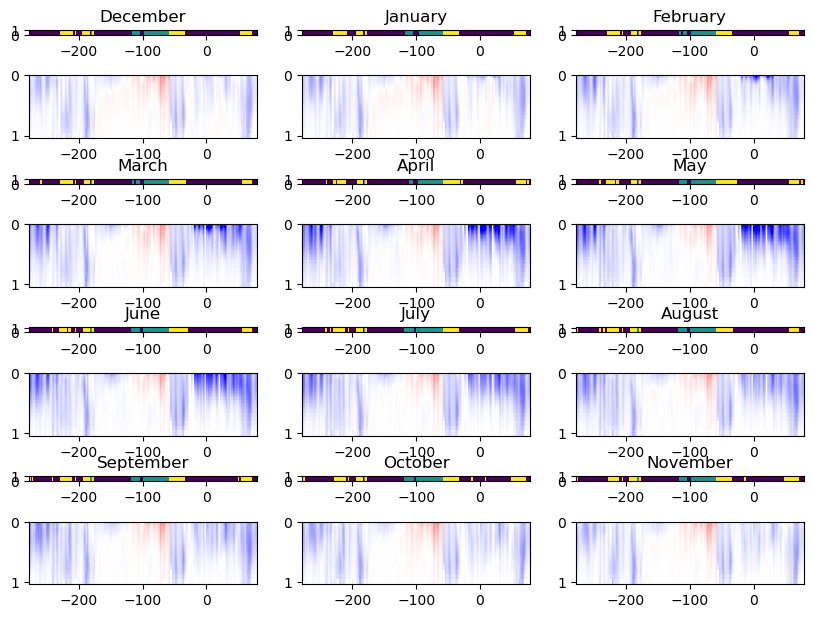

In [37]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1,0.08,1,0.08,1,0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 1.2, wspace=0.2)

label_inds = [0,1,2,6,7,8,12,13,14,18,19,20]
vel_inds = [3,4,5,9,10,11,15,16,17,21,22,23]
seasons_inds = [11,0,1,2,3,4,5,6,7,8,9,10]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for j in range(12):
    axs[label_inds[j]].pcolor(u_along_da_seasons.lon, depth_bins, np.repeat(labels_gmm_seasons[seasons_inds[j]][:,np.newaxis], depth_bins.size, axis=-1).T)
    u_along_da_seasons.isel(month=seasons_inds[j]).plot(ax=axs[vel_inds[j]], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
    axs[vel_inds[j]].invert_yaxis()
    axs[label_inds[j]].set_title(months[seasons_inds[j]])
    axs[vel_inds[j]].set_title('')
    axs[vel_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_xlabel('')
    axs[vel_inds[j]].set_xlabel('')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_seasons_5deg_bins.png', dpi=300, bbox_inches='tight')
# plt.show()

#### Assess u_along and CSHT in regimes

In [38]:
## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(labels_gmm_months).shape[0], np.array(labels_gmm_months).shape[1]))*np.nan

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_gmm_months)==i, 1, np.nan)

clustering_mask = xr.DataArray(labels_masks, dims = {'regime':np.arange(3).size, 'time':u_along_da_months.time.size, \
                                                     'lon':u_along_da_months.lon.size}, coords = {'regime':classes, 'time':u_along_da_months.time, \
                                                     'lon':u_along_da_months.lon})

In [39]:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

# mask CSHT by regimes:
CSHT_months_masked = CSHT_months.expand_dims(dim={"regime": 3})
CSHT_months_masked = CSHT_months_masked*regime_mask

# Group longitudes into 10-degree bins
ds = CSHT_months_masked
CSHT_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

CSHT_months_binned.load()

<xarray.DataArray (regime: 3, time: 732, depth: 75, lon_bins: 71)> Size: 94MB
array([[[[-2.45068122e+09, -8.91853530e+09,  8.27405518e+09, ...,
                      nan,             nan,  2.23936895e+09],
         [-5.96290147e+09, -9.64880285e+09,  5.19437945e+09, ...,
                      nan,             nan,  3.70600519e+09],
         [-8.72062452e+09, -1.02648630e+10,  2.98076361e+09, ...,
                      nan,             nan,  3.82752238e+09],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                      nan,             nan,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                      nan,             nan,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                      nan,             nan,  0.00000000e+00]],

        [[ 4.36641720e+09, -1.18268988e+10,  9.33478128e+08, ...,
                      nan,             nan,  2.11061560e+09],
         [ 5.49047033e+08, -1.29368031e+10, -3.41678261e+09, ...,
                      nan,             nan,  2.76010513e+09],
         [-1.94948752e+09, -1.41311073e+10, -6.60474279e+09, ...,
                      nan,             nan,  3.06641590e+09],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
          -4.19261436e+09, -4.32504028e+09,  3.30810792e+09],
         [            nan,             nan,             nan, ...,
          -5.67874803e+09, -6.21833059e+09,  3.12601617e+09],
         [            nan,             nan,             nan, ...,
          -6.80848509e+09, -7.38982268e+09,  3.71569645e+09],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * depth     (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * regime    (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bins  (lon_bins) object 568B (-278.5, -273.5] ... (71.5, 76.5]

#### calculating correlations for binned along-slope velocies/CSHT

In [40]:
## Average over different time scales to get depth-based correlations

CSHT_annual_binned = CSHT_months_binned.groupby('time.year').mean('time')
U_along_annual_binned = u_along_da_months_binned.groupby('time.year').mean('time')

CSHT_clima_binned = CSHT_months_binned.groupby('time.month').mean('time')
U_along_clima_binned = u_along_da_months_binned.groupby('time.month').mean('time')
                       
CSHT_layerwise_binned = CSHT_months_binned
U_along_layerwise_binned = u_along_da_months_binned


In [41]:
# Save CSHT and U_along for maps of correlation and variance:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

lon_bin_mid = np.arange((-278.5+2.5),(76.5+2.5),5) # for 5-deg bins

# first convert do xarray dataset: CSHT
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], CSHT_layerwise_binned.time.data),
        depth=(['depth'],CSHT_layerwise_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
CSHT_layerwise_binned_xr = xr.DataArray(CSHT_layerwise_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])
# rename vars:
CSHT_layerwise_binned_xr.name = 'CSHT_layerwise_binned'
CSHT_layerwise_binned_xr.to_netcdf(files_path + 'CSHT_layerwise_5degBins.nc', mode='w', format="NETCDF4")

# u_along

coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], u_along_da_months_binned.time.data),
        depth=(['depth'],u_along_da_months_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
u_along_da_months_binned_xr = xr.DataArray(u_along_da_months_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])
# rename vars:
u_along_da_months_binned_xr.name = 'u_along_da_months_binned'
u_along_da_months_binned_xr.to_netcdf(files_path + 'u_along_da_months_5degBins.nc', mode='w', format="NETCDF4")


In [42]:
%%time

# Calculate the regression slope and r^2 for these longitude bins,
# using the U/CSHT*regime masks (averaged over each regime done below before plotting)

# [loop on i(lon_bins) and j(vert-levels)]

len_lonbin = 71 # 5deg bins

slope_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
slope_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

slope_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

for rr in range(3):
    for i in range(len_lonbin):
        for j in range(u_along_da_months_binned.depth.size):            
            slope_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).slope
            stderr_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).stderr
            r_sq_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).rvalue**2
        
            slope_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).slope
            stderr_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).stderr
            r_sq_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).rvalue**2

            slope_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).slope
            stderr_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).stderr
            r_sq_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).rvalue**2


CPU times: user 2min 28s, sys: 5.42 s, total: 2min 33s
Wall time: 2min 27s


In [43]:
##
depth4plot = np.nanmean(depthT_binned, axis=1) # averaged over contour (binned)

slope_annual_reg = np.nanmean(slope_annual, axis=1)
slope_all_reg = np.nanmean(slope_all, axis=1)
slope_clima_reg = np.nanmean(slope_clima, axis=1)

stderr_annual_reg = np.nanmean(stderr_annual, axis=1)
stderr_all_reg = np.nanmean(stderr_all, axis=1)
stderr_clima_reg = np.nanmean(stderr_clima, axis=1)

r_sq_annual_reg = np.nanmean(r_sq_annual, axis=1)
r_sq_all_reg = np.nanmean(r_sq_all, axis=1)
r_sq_clima_reg = np.nanmean(r_sq_clima, axis=1)

# average r^2 800 and bottom;

r_sq_annual_plot = np.nanmean(r_sq_annual[-7:,:,:], axis=0)
r_sq_all_plot = np.nanmean(r_sq_all[-7:,:,:], axis=0)
r_sq_clima_plot = np.nanmean(r_sq_clima[-7:,:,:], axis=0)

In [44]:
slope_annual_wavg_reg = np.nansum(slope_annual, axis=1)
slope_annual_wavg_reg.shape

(50, 3)

In [45]:
## get the latest lon interval value to build mid-point array:

lon_bin_mid = np.arange((-278.5+2.5),(76.5+2.5),5) # for 5-deg bins


Text(0, 0.5, 'r$^{2}$')

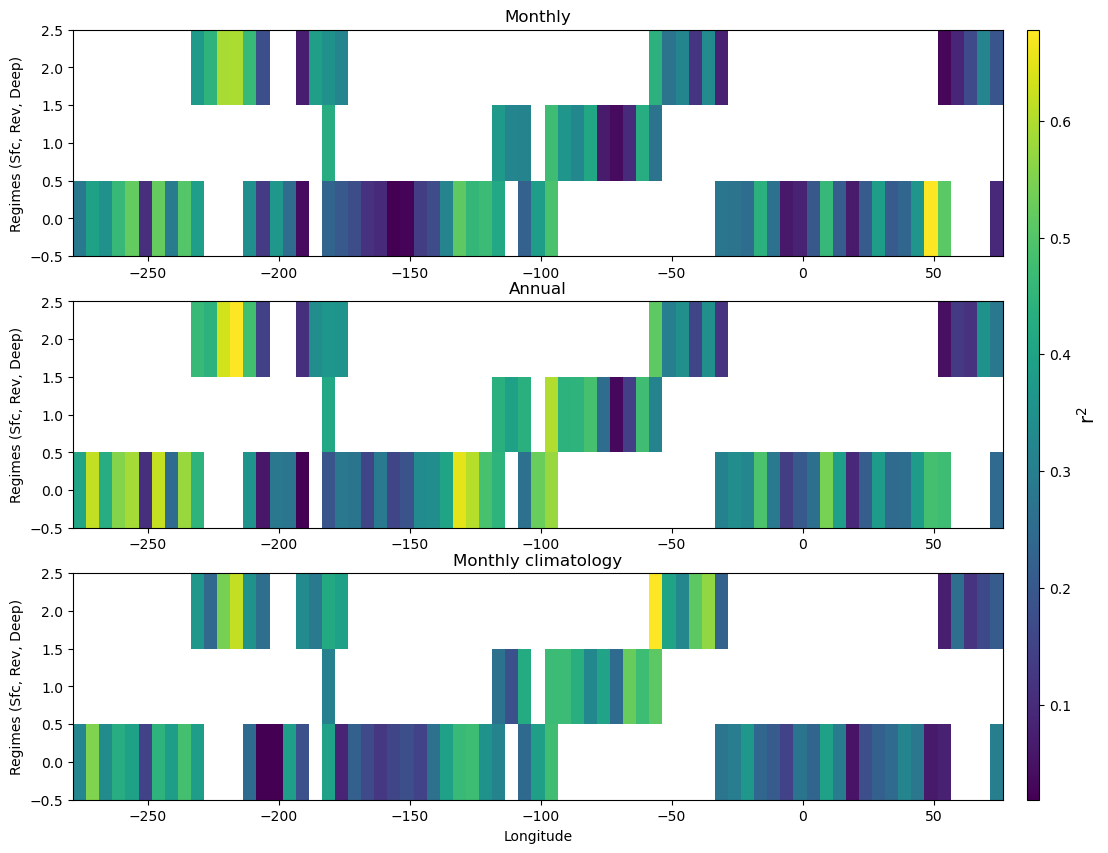

In [46]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,10))

ct1=axs[0].pcolormesh(lon_bin_mid,np.arange(0,3,1),r_sq_annual_plot.transpose())
axs[0].set_ylabel('Regimes (Sfc, Rev, Deep)')
# axs[0].set_xlabel('Longitude')
axs[0].set_title('Monthly')

axs[1].pcolormesh(lon_bin_mid,np.arange(0,3,1),r_sq_all_plot.transpose())
axs[1].set_ylabel('Regimes (Sfc, Rev, Deep)')
# axs[1].set_xlabel('Longitude')
axs[1].set_title('Annual')

axs[2].pcolormesh(lon_bin_mid,np.arange(0,3,1),r_sq_clima_plot.transpose())
axs[2].set_ylabel('Regimes (Sfc, Rev, Deep)')
axs[2].set_xlabel('Longitude')
axs[2].set_title('Monthly climatology')

cbar_ax1 = fig.add_axes([0.92, 0.11, 0.01, 0.77])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('r$^{2}$',fontsize=14)#, labelpad=-35)


#### save r_sq for each time-frequency for specific long. bins:


In [47]:
# first convert do xarray dataset:

coordinatesBin=dict(depth=('depth',depth4plot), lon_bins=(['lon_bin_mid'], lon_bin_mid), regimes=(['regimes'],np.arange(0,3,1)))
    
slope_annual_xr = xr.DataArray(slope_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_all_xr = xr.DataArray(slope_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_clima_xr = xr.DataArray(slope_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

stderr_annual_xr = xr.DataArray(stderr_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_all_xr = xr.DataArray(stderr_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_clima_xr = xr.DataArray(stderr_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

r_sq_annual_xr = xr.DataArray(r_sq_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_all_xr = xr.DataArray(r_sq_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_clima_xr = xr.DataArray(r_sq_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])


# rename vars:
slope_annual_xr.name = 'slope_annual'
slope_all_xr.name = 'slope_all'
slope_clima_xr.name = 'slope_clima'

stderr_annual_xr.name = 'stderr_annual'
stderr_all_xr.name = 'stderr_all'
stderr_clima_xr.name = 'stderr_clima'

r_sq_annual_xr.name = 'r_sq_annual'
r_sq_all_xr.name = 'r_sq_all'
r_sq_clima_xr.name = 'r_sq_clim'

In [48]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

slope_annual_xr.to_netcdf(files_path + 'slope_annual_5degBins.nc', mode='w', format="NETCDF4")
slope_all_xr.to_netcdf(files_path + 'slope_all_5degBins.nc', mode='w', format="NETCDF4")
slope_clima_xr.to_netcdf(files_path + 'slope_clima_5degBins.nc', mode='w', format="NETCDF4")

stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_5degBins.nc', mode='w', format="NETCDF4")
stderr_all_xr.to_netcdf(files_path + 'stderr_all_5degBins.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_5degBins.nc', mode='w', format="NETCDF4")

r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_5degBins.nc', mode='w', format="NETCDF4")
r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_5degBins.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_5degBins.nc', mode='w', format="NETCDF4")



### now doing it for 10deg longitude bins:

In [49]:
# Define bin edges for 10-degree bins
lon_bin=10
# defined 'bin_edges'
bin_edges = np.arange(u_along_da_seasons_masked.lon[0], u_along_da_seasons_masked.lon[-1], lon_bin)

# Group longitudes into bins
ds = u_along_da_mean_masked
u_along_da_mean_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_seasons_masked
u_along_da_seasons_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_months_masked
u_along_da_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_annual_masked
u_along_da_annual_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

#load 
u_along_da_mean_binned.load()
u_along_da_seasons_binned.load()
u_along_da_months_binned.load()
u_along_da_annual_binned.load()

# Group longitudes into 10-degree bins for depth array"
ds = depthT
depthT_binned = ds.groupby_bins('lon_bin_midpoints', bins=bin_edges).mean()
print(ds)

<xarray.DataArray 'depth' (st_ocean: 50, lon_bin_midpoints: 1428)> Size: 571kB
array([[0.54128075, 0.54128075, 0.54128075, ..., 0.54128075, 0.54128075,
        0.54128075],
       [1.68073463, 1.68073463, 1.68073463, ..., 1.68073463, 1.68073463,
        1.68073463],
       [2.93995261, 2.93995261, 2.93995261, ..., 2.93995261, 2.93995261,
        2.93995261],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * st_ocean           (st_ocean) float64 400B 0.5413 1.681 ... 1.333e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25


In [50]:
#### Assess u_along and CSHT in regimes

## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(labels_gmm_months).shape[0], np.array(labels_gmm_months).shape[1]))*np.nan

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_gmm_months)==i, 1, np.nan)

clustering_mask = xr.DataArray(labels_masks, dims = {'regime':np.arange(3).size, 'time':u_along_da_months.time.size, \
                                                     'lon':u_along_da_months.lon.size}, coords = {'regime':classes, 'time':u_along_da_months.time, \
                                                     'lon':u_along_da_months.lon})

CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

# mask CSHT by regimes:
CSHT_months_masked = CSHT_months.expand_dims(dim={"regime": 3})
CSHT_months_masked = CSHT_months_masked*regime_mask

# Group longitudes into 10-degree bins
ds = CSHT_months_masked
CSHT_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

CSHT_months_binned.load()

<xarray.DataArray (regime: 3, time: 732, depth: 75, lon_bins: 35)> Size: 46MB
array([[[[-5.68460826e+09,  1.22272638e+09, -9.58649985e+09, ...,
          -8.28642130e+09, -1.57892387e+10,             nan],
         [-7.80585216e+09, -8.14443634e+08, -1.11277949e+10, ...,
          -1.10319560e+10, -1.85040966e+10,             nan],
         [-9.49274374e+09, -2.37558065e+09, -1.22500673e+10, ...,
          -1.30337046e+10, -2.05889591e+10,             nan],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,             nan],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,             nan],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,             nan]],

        [[-3.73024078e+09, -3.70469532e+09, -6.90903372e+09, ...,
          -2.31989591e+09, -6.75124268e+09,             nan],
         [-6.19387801e+09, -6.18025718e+09, -9.36315376e+09, ...,
          -4.82594739e+09, -9.74996920e+09,             nan],
         [-8.04029739e+09, -8.17598970e+09, -1.12855248e+10, ...,
          -6.46153829e+09, -1.17646907e+10,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan, -6.87832759e+09, -4.25882732e+09],
         [            nan,             nan,             nan, ...,
                      nan, -7.53857520e+09, -5.94853931e+09],
         [            nan,             nan,             nan, ...,
                      nan, -8.10679187e+09, -7.09915389e+09],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * depth     (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * regime    (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bins  (lon_bins) object 280B (-278.5, -268.5] ... (61.5, 71.5]

In [51]:
lon_bin_mid = np.arange((-278.5+5),(71.5+5),10) # for 10-deg bins


In [52]:
#### calculating correlations for binned along-slope velocies/CSHT
files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

## Average over different time scales to get depth-based correlations

CSHT_annual_binned = CSHT_months_binned.groupby('time.year').mean('time')
U_along_annual_binned = u_along_da_months_binned.groupby('time.year').mean('time')

CSHT_clima_binned = CSHT_months_binned.groupby('time.month').mean('time')
U_along_clima_binned = u_along_da_months_binned.groupby('time.month').mean('time')
                       
CSHT_layerwise_binned = CSHT_months_binned
U_along_layerwise_binned = u_along_da_months_binned

# --- Save CSHT and U_along for maps of correlation and variance:

# get the latest lon interval value to build mid-point array:
lon_bin_mid = np.arange((-278.5+5),(71.5+5),10) # for 10-deg bins

# first convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], CSHT_layerwise_binned.time.data),
        depth=(['depth'],CSHT_layerwise_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
    
CSHT_layerwise_binned_xr = xr.DataArray(CSHT_layerwise_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])

# rename vars:
CSHT_layerwise_binned_xr.name = 'CSHT_layerwise_binned'

CSHT_layerwise_binned_xr.to_netcdf(files_path + 'CSHT_layerwise_10degBins.nc', mode='w', format="NETCDF4")

# firstly, convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], u_along_da_months_binned.time.data),
        depth=(['depth'],u_along_da_months_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
u_along_da_months_binned_xr = xr.DataArray(u_along_da_months_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])

# rename vars:
u_along_da_months_binned_xr.name = 'u_along_da_months_binned'

u_along_da_months_binned_xr.to_netcdf(files_path + 'u_along_da_months_10degBins.nc', mode='w', format="NETCDF4")


In [53]:
%%time

# Calculate the regression slope and r^2 for these longitude bins,
# using the U/CSHT*regime masks (averaged over each regime done below before plotting)

# [loop on i(lon_bins) and j(v-levs)]

len_lonbin = 35 # 10deg bins

slope_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
slope_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

slope_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

for rr in range(3):
    for i in range(len_lonbin):
        for j in range(u_along_da_months_binned.depth.size):
            # mask_regime_tmp = regimes_mask_binned.regimes_mask.isel(regime=rr, lon_bins=i)
            
            slope_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).slope
            stderr_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).stderr
            r_sq_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).rvalue**2
        
            slope_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).slope
            stderr_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).stderr
            r_sq_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).rvalue**2

            slope_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).slope
            stderr_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).stderr
            r_sq_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).rvalue**2


CPU times: user 1min 14s, sys: 2.8 s, total: 1min 17s
Wall time: 1min 14s


In [54]:
#### save r_sq for each time-frequency for specific long. bins:

# first convert do xarray dataset:

coordinatesBin=dict(depth=('depth',depth4plot), lon_bins=(['lon_bin_mid'], lon_bin_mid), regimes=(['regimes'],np.arange(0,3,1)))
    
slope_annual_xr = xr.DataArray(slope_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_all_xr = xr.DataArray(slope_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_clima_xr = xr.DataArray(slope_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

stderr_annual_xr = xr.DataArray(stderr_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_all_xr = xr.DataArray(stderr_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_clima_xr = xr.DataArray(stderr_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

r_sq_annual_xr = xr.DataArray(r_sq_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_all_xr = xr.DataArray(r_sq_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_clima_xr = xr.DataArray(r_sq_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])


# rename vars:
slope_annual_xr.name = 'slope_annual'
slope_all_xr.name = 'slope_all'
slope_clima_xr.name = 'slope_clima'

stderr_annual_xr.name = 'stderr_annual'
stderr_all_xr.name = 'stderr_all'
stderr_clima_xr.name = 'stderr_clima'

r_sq_annual_xr.name = 'r_sq_annual'
r_sq_all_xr.name = 'r_sq_all'
r_sq_clima_xr.name = 'r_sq_clim'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

slope_annual_xr.to_netcdf(files_path + 'slope_annual_10degBins.nc', mode='w', format="NETCDF4")
slope_all_xr.to_netcdf(files_path + 'slope_all_10degBins.nc', mode='w', format="NETCDF4")
slope_clima_xr.to_netcdf(files_path + 'slope_clima_10degBins.nc', mode='w', format="NETCDF4")

stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_10degBins.nc', mode='w', format="NETCDF4")
stderr_all_xr.to_netcdf(files_path + 'stderr_all_10degBins.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_10degBins.nc', mode='w', format="NETCDF4")

r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_10degBins.nc', mode='w', format="NETCDF4")
r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_10degBins.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_10degBins.nc', mode='w', format="NETCDF4")


### now doing it for 15deg longitude bins:

In [55]:
# Define bin edges for 15-degree bins
lon_bin=15
# defined 'bin_edges'
bin_edges = np.arange(u_along_da_seasons_masked.lon[0], u_along_da_seasons_masked.lon[-1], lon_bin)

# Group longitudes into 5-degree bins
ds = u_along_da_mean_masked
u_along_da_mean_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_seasons_masked
u_along_da_seasons_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_months_masked
u_along_da_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_annual_masked
u_along_da_annual_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

#load 
u_along_da_mean_binned.load()
u_along_da_seasons_binned.load()
u_along_da_months_binned.load()
u_along_da_annual_binned.load()

<xarray.DataArray (regime: 3, year: 61, st_ocean: 75, lon_bins: 23)> Size: 3MB
array([[[[-0.15810241, -0.16012601, -0.13960117, ..., -0.2120527 ,
          -0.17609083, -0.23715534],
         [-0.14543918, -0.14607285, -0.12441705, ..., -0.19881013,
          -0.15683621, -0.21096616],
         [-0.13836069, -0.13842684, -0.11595754, ..., -0.19084747,
          -0.14608079, -0.19662757],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[-0.13731383, -0.1352867 , -0.12391426, ..., -0.19894713,
          -0.17018936, -0.23494831],
         [-0.12430083, -0.12177355, -0.11161865, ..., -0.18799368,
          -0.15294492, -0.2076126 ],
         [-0.11712484, -0.11440333, -0.10472448, ..., -0.18096317,
          -0.14342204, -0.19276383],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan, -0.16319622],
         [        nan,         nan,         nan, ...,         nan,
                  nan, -0.14545155],
         [        nan,         nan,         nan, ...,         nan,
                  nan, -0.13571682],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * year      (year) int64 488B 1958 1959 1960 1961 1962 ... 2015 2016 2017 2018
  * regime    (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bins  (lon_bins) object 184B (-278.5, -263.5] ... (51.5, 66.5]

In [56]:
# Group longitudes into 15-degree bins for depth array"
ds = depthT
depthT_binned = ds.groupby_bins('lon_bin_midpoints', bins=bin_edges).mean()
print(ds)


<xarray.DataArray 'depth' (st_ocean: 50, lon_bin_midpoints: 1428)> Size: 571kB
array([[0.54128075, 0.54128075, 0.54128075, ..., 0.54128075, 0.54128075,
        0.54128075],
       [1.68073463, 1.68073463, 1.68073463, ..., 1.68073463, 1.68073463,
        1.68073463],
       [2.93995261, 2.93995261, 2.93995261, ..., 2.93995261, 2.93995261,
        2.93995261],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * st_ocean           (st_ocean) float64 400B 0.5413 1.681 ... 1.333e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25


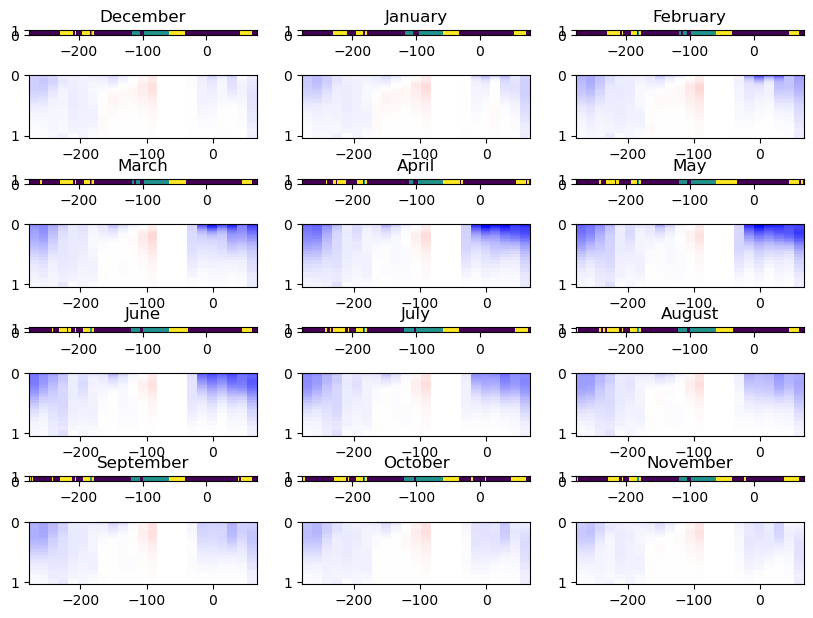

In [57]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1,0.08,1,0.08,1,0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 1.2, wspace=0.2)

label_inds = [0,1,2,6,7,8,12,13,14,18,19,20]
vel_inds = [3,4,5,9,10,11,15,16,17,21,22,23]
seasons_inds = [11,0,1,2,3,4,5,6,7,8,9,10]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for j in range(12):
    axs[label_inds[j]].pcolor(u_along_da_seasons.lon, depth_bins, np.repeat(labels_gmm_seasons[seasons_inds[j]][:,np.newaxis], depth_bins.size, axis=-1).T)
    u_along_da_seasons_binned.isel(regime=0,month=seasons_inds[j]).plot(ax=axs[vel_inds[j]], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
    axs[vel_inds[j]].invert_yaxis()
    axs[label_inds[j]].set_title(months[seasons_inds[j]])
    axs[vel_inds[j]].set_title('')
    axs[vel_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_xlabel('')
    axs[vel_inds[j]].set_xlabel('')
plt.savefig('/g/data/hh5/tmp/access-om/fbd581/ASC_project/ASC_and_heat_transport/figs/GMM_ASC_trained_seasons_15degBins_v2_surface.png', dpi=300, bbox_inches='tight')
plt.show()

#### Assess u_along and CSHT in regimes

In [58]:
## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(labels_gmm_months).shape[0], np.array(labels_gmm_months).shape[1]))*np.nan

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_gmm_months)==i, 1, np.nan)

clustering_mask = xr.DataArray(labels_masks, dims = {'regime':np.arange(3).size, 'time':u_along_da_months.time.size, \
                                                     'lon':u_along_da_months.lon.size}, coords = {'regime':classes, 'time':u_along_da_months.time, \
                                                     'lon':u_along_da_months.lon})

In [59]:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

# mask CSHT by regimes:
CSHT_months_masked = CSHT_months.expand_dims(dim={"regime": 3})
CSHT_months_masked = CSHT_months_masked*regime_mask

# Group longitudes into 15-degree bins
ds = CSHT_months_masked
CSHT_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

CSHT_months_binned.load()

<xarray.DataArray (regime: 3, time: 732, depth: 75, lon_bins: 23)> Size: 30MB
array([[[[-1.03172045e+09, -8.33386737e+09, -9.00982127e+09, ...,
          -3.17958292e+09, -9.12363493e+09, -1.57892387e+10],
         [-3.47244162e+09, -9.69295220e+09, -1.09558575e+10, ...,
          -4.51749049e+09, -1.14313195e+10, -1.85040966e+10],
         [-5.33490795e+09, -1.07440198e+10, -1.20974939e+10, ...,
          -5.47807046e+09, -1.31547034e+10, -2.05889591e+10],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[-2.17566781e+09, -7.38697874e+09, -4.10932790e+09, ...,
          -6.25611300e+09, -4.12075195e+09, -6.75124268e+09],
         [-5.26817955e+09, -9.22334642e+09, -6.03173969e+09, ...,
          -7.66903062e+09, -6.17337133e+09, -9.74996920e+09],
         [-7.56177919e+09, -1.07727621e+10, -7.31665743e+09, ...,
          -8.70048532e+09, -7.60127332e+09, -1.17646907e+10],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan, -5.56822358e+09],
         [            nan,             nan,             nan, ...,
                      nan,             nan, -6.63134243e+09],
         [            nan,             nan,             nan, ...,
                      nan,             nan, -7.47347149e+09],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * depth     (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * regime    (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bins  (lon_bins) object 184B (-278.5, -263.5] ... (51.5, 66.5]

#### calculating correlations for binned along-slope velocies/CSHT

In [60]:
## Average over different time scales to get depth-based correlations

CSHT_annual_binned = CSHT_months_binned.groupby('time.year').mean('time')
U_along_annual_binned = u_along_da_months_binned.groupby('time.year').mean('time')

CSHT_clima_binned = CSHT_months_binned.groupby('time.month').mean('time')
U_along_clima_binned = u_along_da_months_binned.groupby('time.month').mean('time')
                       
CSHT_layerwise_binned = CSHT_months_binned
U_along_layerwise_binned = u_along_da_months_binned


In [61]:
# Save CSHT and U_along for maps of correlation and variance:

# get the latest lon interval value to build mid-point array:
lon_bin_mid = np.arange((-278.5+7.5),(66.5+7.5),15) # for 15-deg bins

# first convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], CSHT_layerwise_binned.time.data),
        depth=(['depth'],CSHT_layerwise_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
    
CSHT_layerwise_binned_xr = xr.DataArray(CSHT_layerwise_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])


# rename vars:
CSHT_layerwise_binned_xr.name = 'CSHT_layerwise_binned'

CSHT_layerwise_binned_xr.to_netcdf(files_path + 'CSHT_layerwise_15degBins.nc', mode='w', format="NETCDF4")

# first convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], u_along_da_months_binned.time.data),
        depth=(['depth'],u_along_da_months_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
u_along_da_months_binned_xr = xr.DataArray(u_along_da_months_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])


# rename vars:
u_along_da_months_binned_xr.name = 'u_along_da_months_binned'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

u_along_da_months_binned_xr.to_netcdf(files_path + 'u_along_da_months_15degBins.nc', mode='w', format="NETCDF4")


In [62]:
%%time

# Calculate the regression slope and r^2 for these longitude bins,
# using the U/CSHT*regime masks (averaged over each regime done below before plotting)

# [loop on i(lon_bins) and j(v-levs)]

len_lonbin = 23 # 15deg bins

slope_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
slope_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

# slope_deseasoned = np.zeros((u_along_da_months_binned.depth.size, len_lonbin))
# stderr_deseasoned = np.zeros((u_along_da_months_binned.depth.size, len_lonbin))
# r_sq_deseasoned = np.zeros((u_along_da_months_binned.depth.size, len_lonbin))
slope_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

for rr in range(3):
    for i in range(len_lonbin):
        for j in range(u_along_da_months_binned.depth.size):
            # mask_regime_tmp = regimes_mask_binned.regimes_mask.isel(regime=rr, lon_bins=i)
            
            slope_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).slope
            stderr_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).stderr
            r_sq_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).rvalue**2
        
            slope_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).slope
            stderr_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).stderr
            r_sq_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).rvalue**2

            slope_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).slope
            stderr_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).stderr
            r_sq_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).rvalue**2


CPU times: user 48.3 s, sys: 1.73 s, total: 50 s
Wall time: 48.1 s


#### save r_sq for each time-frequency for specific long. bins:


In [63]:
# first convert do xarray dataset:

coordinatesBin=dict(depth=('depth',depth4plot), lon_bins=(['lon_bin_mid'], lon_bin_mid), regimes=(['regimes'],np.arange(0,3,1)))
    
slope_annual_xr = xr.DataArray(slope_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_all_xr = xr.DataArray(slope_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_clima_xr = xr.DataArray(slope_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

stderr_annual_xr = xr.DataArray(stderr_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_all_xr = xr.DataArray(stderr_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_clima_xr = xr.DataArray(stderr_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

r_sq_annual_xr = xr.DataArray(r_sq_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_all_xr = xr.DataArray(r_sq_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_clima_xr = xr.DataArray(r_sq_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])


# rename vars:
slope_annual_xr.name = 'slope_annual'
slope_all_xr.name = 'slope_all'
slope_clima_xr.name = 'slope_clima'

stderr_annual_xr.name = 'stderr_annual'
stderr_all_xr.name = 'stderr_all'
stderr_clima_xr.name = 'stderr_clima'

r_sq_annual_xr.name = 'r_sq_annual'
r_sq_all_xr.name = 'r_sq_all'
r_sq_clima_xr.name = 'r_sq_clim'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

slope_annual_xr.to_netcdf(files_path + 'slope_annual_15degBins.nc', mode='w', format="NETCDF4")
slope_all_xr.to_netcdf(files_path + 'slope_all_15degBins.nc', mode='w', format="NETCDF4")
slope_clima_xr.to_netcdf(files_path + 'slope_clima_15degBins.nc', mode='w', format="NETCDF4")

stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_15degBins.nc', mode='w', format="NETCDF4")
stderr_all_xr.to_netcdf(files_path + 'stderr_all_15degBins.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_15degBins.nc', mode='w', format="NETCDF4")

r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_15degBins.nc', mode='w', format="NETCDF4")
r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_15degBins.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_15degBins.nc', mode='w', format="NETCDF4")


### now doing it for 20deg longitude bins:

Testing 2 types of bin_edges; this will affect the weighting in the first and last bins, which have less gridpoints than other bins.
Choose just one of the types below (and comment the others):

In [103]:
# # 1) bin edges b/w -280:80
# #    - weight 1st/last bins accordingly (i.e., max 74 pts, not 80 as all other bins)
# lon_bin=20
# bin_edges = np.arange(-280, u_along_da_seasons_masked.lon[-1]+(lon_bin/2), lon_bin)
# print(bin_edges)


# 2) bin edges b/w -278.5:81.5
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
lon_bin=20
bin_edges = np.arange(u_along_da_seasons_masked.lon[0], u_along_da_seasons_masked.lon[-1]+(lon_bin/2), lon_bin)
print(bin_edges)


# 3) bin edges b/w -278.5:78.5 (missing one bin, here just for legacy)
#    - weight last bin accordingly (i.e., max 74 pts, not 80 as all other bins)
# lon_bin=20
# bin_edges = np.arange(u_along_da_seasons_masked.lon[0], u_along_da_seasons_masked.lon[-1], lon_bin)
# print(bin_edges)

[-278.5 -258.5 -238.5 -218.5 -198.5 -178.5 -158.5 -138.5 -118.5  -98.5
  -78.5  -58.5  -38.5  -18.5    1.5   21.5   41.5   61.5   81.5]


In [104]:
# get the latest lon interval value to build mid-point array:
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 20-deg bins

print(lon_bin_mid)

[-268.5 -248.5 -228.5 -208.5 -188.5 -168.5 -148.5 -128.5 -108.5  -88.5
  -68.5  -48.5  -28.5   -8.5   11.5   31.5   51.5   71.5]


In [274]:
# Group longitudes into bins

# For test 1:
# ds = u_along_da_mean_masked
# u_along_da_mean_binned = ds.groupby_bins('lon', bins=bin_edges).mean()


# For test 2:
#- 1st append the first 12 points along the contour in the end, so all bins have the same n of points 
u_along_da_mean_masked_halo = xr.concat([u_along_da_mean_masked,
                                        u_along_da_mean_masked.isel(lon=slice(0,12))],
                                        dim='lon')
#-2nd change the lon values to be within the last bin:
newlon = np.concatenate((u_along_da_mean_masked.lon.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon': newlon},dims=['lon'])
u_along_da_mean_masked_halo['lon'] = longfix
ds = u_along_da_mean_masked_halo
u_along_da_mean_binned = ds.groupby_bins('lon', bins=bin_edges).mean()


In [ ]:
# %%time

# # --- This cell is for Test 1:

# # Define bin edges for 20-degree bins

# # Group longitudes into bins
# ds = u_along_da_mean_masked
# u_along_da_mean_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

# ds = u_along_da_seasons_masked
# u_along_da_seasons_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

# ds = u_along_da_months_masked
# u_along_da_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

# ds = u_along_da_annual_masked
# u_along_da_annual_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

# #load 
# u_along_da_mean_binned.load()
# u_along_da_seasons_binned.load()
# u_along_da_months_binned.load()
# u_along_da_annual_binned.load()

# # Group longitudes into 20-degree bins for depth array"
# ds = depthT_halo
# depthT_binned = ds.groupby_bins('lon_bin_midpoints', bins=bin_edges).mean()
# print(ds)
# depth4plot = np.nanmean(depthT_binned, axis=1) # averaged over contour (binned)

In [275]:
%%time

# --- This cell is for Test 2:

# Define bin edges for 20-degree bins

# Group longitudes into bins
u_along_da_mean_masked_halo = xr.concat([u_along_da_mean_masked,
                                        u_along_da_mean_masked.isel(lon=slice(0,12))],
                                        dim='lon')
u_along_da_mean_masked_halo['lon'] = longfix
ds = u_along_da_mean_masked_halo
u_along_da_mean_binned = ds.groupby_bins('lon', bins=bin_edges).mean()
# -- 
u_along_da_seasons_masked_halo = xr.concat([u_along_da_seasons_masked,
                                        u_along_da_seasons_masked.isel(lon=slice(0,12))],
                                        dim='lon')
u_along_da_seasons_masked_halo['lon'] = longfix
ds = u_along_da_seasons_masked_halo
u_along_da_seasons_binned = ds.groupby_bins('lon', bins=bin_edges).mean()
# -- 
u_along_da_months_masked_halo = xr.concat([u_along_da_months_masked,
                                        u_along_da_months_masked.isel(lon=slice(0,12))],
                                        dim='lon')
u_along_da_months_masked_halo['lon'] = longfix
ds = u_along_da_months_masked_halo
u_along_da_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()
# --
u_along_da_annual_masked_halo = xr.concat([u_along_da_annual_masked,
                                        u_along_da_annual_masked.isel(lon=slice(0,12))],
                                        dim='lon')
u_along_da_annual_masked_halo['lon'] = longfix
ds = u_along_da_annual_masked_halo
u_along_da_annual_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

#load 
u_along_da_mean_binned.load()
u_along_da_seasons_binned.load()
u_along_da_months_binned.load()
u_along_da_annual_binned.load()

# Group longitudes into 20-degree bins for depth array"
depthT_halo = xr.concat([depthT,depthT.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
depthT_halo['lon_bin_midpoints'] = longfix
ds = depthT_halo
depthT_binned = ds.groupby_bins('lon_bin_midpoints', bins=bin_edges).mean()
print(ds)
depth4plot = np.nanmean(depthT_binned, axis=1) # averaged over contour (binned)

<xarray.DataArray 'depth' (st_ocean: 50, lon_bin_midpoints: 1440)> Size: 576kB
array([[0.54128075, 0.54128075, 0.54128075, ..., 0.54128075, 0.54128075,
        0.54128075],
       [1.68073463, 1.68073463, 1.68073463, ..., 1.68073463, 1.68073463,
        1.68073463],
       [2.93995261, 2.93995261, 2.93995261, ..., 2.93995261, 2.93995261,
        2.93995261],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * st_ocean           (st_ocean) float64 400B 0.5413 1.681 ... 1.333e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 12kB -278.5 -278.2 ... 81.25
CPU times: user 3.91 s, sys: 1.92 s, total: 5.83 s
Wall time: 5.3 s


In [279]:
regime_mask_halo = xr.concat([regime_mask,regime_mask.isel(lon=slice(0,12))],dim='lon')
longfix = xr.DataArray(newlon, coords={'lon': newlon},dims=['lon'])
regime_mask_halo['lon'] = longfix


In [298]:
# count number of grid-points for weighting:
# u_along_da_seasons_masked.lon[-1]+(lon_bin/2)
# print(bin_edges.shape)
weight_20deg = np.empty((len(lon_bin_mid),3))

for rr in range(0,3):
    for aa in range(0,len(lon_bin_mid)):
        lower_lon = bin_edges[aa]
        upper_lon = bin_edges[aa+1]
        if rr==0:
            print(lower_lon, upper_lon)
        pts_w_range = u_along_da_mean_masked_halo.lon[(u_along_da_mean_masked_halo.isel(regime=rr).lon*regime_mask_halo.isel(regime=rr) >= lower_lon) 
                                                    & (u_along_da_mean_masked_halo.isel(regime=rr).lon*regime_mask_halo.isel(regime=rr) < upper_lon)]        

        npts = len(pts_w_range)

        weight_20deg[aa,rr] = npts
        del pts_w_range, npts

-278.5 -258.5
-258.5 -238.5
-238.5 -218.5
-218.5 -198.5
-198.5 -178.5
-178.5 -158.5
-158.5 -138.5
-138.5 -118.5
-118.5 -98.5
-98.5 -78.5
-78.5 -58.5
-58.5 -38.5
-38.5 -18.5
-18.5 1.5
1.5 21.5
21.5 41.5
41.5 61.5
61.5 81.5


In [281]:
weight_20deg

array([[80.,  0.,  0.],
       [80.,  0.,  0.],
       [39.,  0., 41.],
       [39.,  0., 41.],
       [30.,  8., 42.],
       [68.,  0., 12.],
       [80.,  0.,  0.],
       [80.,  0.,  0.],
       [28., 52.,  0.],
       [ 3., 77.,  0.],
       [ 0., 80.,  0.],
       [ 0.,  4., 76.],
       [55.,  0., 25.],
       [80.,  0.,  0.],
       [80.,  0.,  0.],
       [80.,  0.,  0.],
       [60.,  0., 20.],
       [37.,  0., 43.]])

In [286]:
# Appending last bin for CSHT (test 2)
CSHT_along_halo = xr.concat([CSHT_along, CSHT_along.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
CSHT_along_halo['lon_bin_midpoints'] = longfix


In [290]:
#### Assess u_along and CSHT in regimes

## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(labels_gmm_months).shape[0], np.array(labels_gmm_months).shape[1]))*np.nan

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_gmm_months)==i, 1, np.nan)

clustering_mask = xr.DataArray(labels_masks, dims = {'regime':np.arange(3).size, 'time':u_along_da_months.time.size, \
                                                     'lon':u_along_da_months.lon.size}, coords = {'regime':classes, 'time':u_along_da_months.time, \
                                                     'lon':u_along_da_months.lon})

# --- section for test 1:
# CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
# CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

# # mask CSHT by regimes:
# CSHT_months_masked = CSHT_months.expand_dims(dim={"regime": 3})
# CSHT_months_masked = CSHT_months_masked*regime_mask

# # Group longitudes into 20-degree bins
# ds = CSHT_months_masked
# CSHT_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

# CSHT_months_binned.load()
# ---

# --- section for test 2:
CSHT_along_monthly = CSHT_along_halo.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

# mask CSHT by regimes:
CSHT_months_masked = CSHT_months.expand_dims(dim={"regime": 3})
CSHT_months_masked = CSHT_months_masked*regime_mask_halo

# Group longitudes into 20-degree bins
ds = CSHT_months_masked
CSHT_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

CSHT_months_binned.load()

<xarray.DataArray (regime: 3, time: 732, depth: 75, lon_bins: 18)> Size: 24MB
array([[[[-2.23094094e+09, -9.53237475e+09, -4.76797967e+09, ...,
          -5.08420274e+09, -1.07025828e+10, -3.18339896e+09],
         [-4.31014790e+09, -1.10638483e+10, -7.12095474e+09, ...,
          -6.44562947e+09, -1.34382386e+10, -4.15521091e+09],
         [-5.93416219e+09, -1.20750985e+10, -8.62055151e+09, ...,
          -7.45772808e+09, -1.54667527e+10, -5.46701041e+09],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[-3.71746805e+09, -5.43983894e+09, -3.13234613e+09, ...,
          -6.62270076e+09, -3.74693978e+09,  1.06875935e+09],
         [-6.18706759e+09, -7.42080779e+09, -5.29645036e+09, ...,
          -7.96882777e+09, -6.41164933e+09, -2.66450490e+08],
         [-8.10814354e+09, -8.89844240e+09, -6.78447020e+09, ...,
          -8.99554984e+09, -8.16933315e+09, -1.22758809e+09],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan, -2.96188619e+09, ...,
                      nan, -6.87832759e+09, -3.89849707e+09],
         [            nan,             nan, -4.67233148e+09, ...,
                      nan, -7.53857520e+09, -5.51641762e+09],
         [            nan,             nan, -5.85034422e+09, ...,
                      nan, -8.10679187e+09, -6.58416101e+09],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * depth     (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * regime    (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bins  (lon_bins) object 144B (-278.5, -258.5] ... (61.5, 81.5]

In [292]:
#### calculating correlations for binned along-slope velocies/CSHT
files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

## Average over different time scales to get depth-based correlations

CSHT_annual_binned = CSHT_months_binned.groupby('time.year').mean('time')
U_along_annual_binned = u_along_da_months_binned.groupby('time.year').mean('time')

CSHT_clima_binned = CSHT_months_binned.groupby('time.month').mean('time')
U_along_clima_binned = u_along_da_months_binned.groupby('time.month').mean('time')
                       
CSHT_layerwise_binned = CSHT_months_binned
U_along_layerwise_binned = u_along_da_months_binned

# Save CSHT and U_along for maps of correlation and variance:

# first convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], CSHT_layerwise_binned.time.data),
        depth=(['depth'],CSHT_layerwise_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
    
CSHT_layerwise_binned_xr = xr.DataArray(CSHT_layerwise_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])


# rename vars:
CSHT_layerwise_binned_xr.name = 'CSHT_layerwise_binned'

# CSHT_layerwise_binned_xr.to_netcdf(files_path + 'CSHT_layerwise_20degBins.nc', mode='w', format="NETCDF4")
# CSHT_layerwise_binned_xr.to_netcdf(files_path + 'CSHT_layerwise_20degBins_t1.nc', mode='w', format="NETCDF4")
CSHT_layerwise_binned_xr.to_netcdf(files_path + 'CSHT_layerwise_20degBins_t2.nc', mode='w', format="NETCDF4")

# firstly, convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], u_along_da_months_binned.time.data),
        depth=(['depth'],u_along_da_months_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
u_along_da_months_binned_xr = xr.DataArray(u_along_da_months_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])


# rename vars:
u_along_da_months_binned_xr.name = 'u_along_da_months_binned'

# u_along_da_months_binned_xr.to_netcdf(files_path + 'u_along_da_months_20degBins.nc', mode='w', format="NETCDF4")
# u_along_da_months_binned_xr.to_netcdf(files_path + 'u_along_da_months_20degBins_t1.nc', mode='w', format="NETCDF4")
u_along_da_months_binned_xr.to_netcdf(files_path + 'u_along_da_months_20degBins_t2.nc', mode='w', format="NETCDF4")


In [294]:
%%time

# Calculate the regression slope and r^2 for these longitude bins,
# using the U/CSHT*regime masks (averaged over each regime done below before plotting)

# [loop on i(lon_bins) and j(v-levs)]

len_lonbin = len(lon_bin_mid)

slope_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
slope_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

slope_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

for rr in range(3):
    for i in range(len_lonbin):
        for j in range(u_along_da_months_binned.depth.size):
            # mask_regime_tmp = regimes_mask_binned.regimes_mask.isel(regime=rr, lon_bins=i)
            
            slope_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).slope
            stderr_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).stderr
            r_sq_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).rvalue**2
        
            slope_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).slope
            stderr_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).stderr
            r_sq_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).rvalue**2

            slope_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).slope
            stderr_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).stderr
            r_sq_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).rvalue**2


CPU times: user 34.9 s, sys: 1.41 s, total: 36.3 s
Wall time: 34.7 s


In [297]:
#### save r_sq for each time-frequency for specific long. bins:

# first convert do xarray dataset:
depth_20deg= np.nanmean(depthT_binned, axis=1) # averaged over contour (binned)

coordinatesBin=dict(depth=('depth',depth_20deg), lon_bins=(['lon_bin_mid'], lon_bin_mid), regimes=(['regimes'],np.arange(0,3,1)))
    
slope_annual_xr = xr.DataArray(slope_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_all_xr = xr.DataArray(slope_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_clima_xr = xr.DataArray(slope_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

stderr_annual_xr = xr.DataArray(stderr_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_all_xr = xr.DataArray(stderr_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_clima_xr = xr.DataArray(stderr_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

r_sq_annual_xr = xr.DataArray(r_sq_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_all_xr = xr.DataArray(r_sq_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_clima_xr = xr.DataArray(r_sq_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])


# rename vars:
slope_annual_xr.name = 'slope_annual'
slope_all_xr.name = 'slope_all'
slope_clima_xr.name = 'slope_clima'

stderr_annual_xr.name = 'stderr_annual'
stderr_all_xr.name = 'stderr_all'
stderr_clima_xr.name = 'stderr_clima'

r_sq_annual_xr.name = 'r_sq_annual'
r_sq_all_xr.name = 'r_sq_all'
r_sq_clima_xr.name = 'r_sq_clim'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'


# --- Saving test 1 ncdf files; use bin edges -280:80
# slope_annual_xr.to_netcdf(files_path + 'slope_annual_20degBins_t1.nc', mode='w', format="NETCDF4")
# slope_all_xr.to_netcdf(files_path + 'slope_all_20degBins_t1.nc', mode='w', format="NETCDF4")
# slope_clima_xr.to_netcdf(files_path + 'slope_clima_20degBins_t1.nc', mode='w', format="NETCDF4")

# stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_20degBins_t1.nc', mode='w', format="NETCDF4")
# stderr_all_xr.to_netcdf(files_path + 'stderr_all_20degBins_t1.nc', mode='w', format="NETCDF4")
# stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_20degBins_t1.nc', mode='w', format="NETCDF4")

# r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_20degBins_t1.nc', mode='w', format="NETCDF4")
# r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_20degBins_t1.nc', mode='w', format="NETCDF4")
# r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_20degBins_t1.nc', mode='w', format="NETCDF4")


# --- Saving test 2 ncdf files; use bin edges -278.5:81.5
slope_annual_xr.to_netcdf(files_path + 'slope_annual_20degBins_t2.nc', mode='w', format="NETCDF4")
slope_all_xr.to_netcdf(files_path + 'slope_all_20degBins_t2.nc', mode='w', format="NETCDF4")
slope_clima_xr.to_netcdf(files_path + 'slope_clima_20degBins_t2.nc', mode='w', format="NETCDF4")

stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_20degBins_t2.nc', mode='w', format="NETCDF4")
stderr_all_xr.to_netcdf(files_path + 'stderr_all_20degBins_t2.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_20degBins_t2.nc', mode='w', format="NETCDF4")

r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_20degBins_t2.nc', mode='w', format="NETCDF4")
r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_20degBins_t2.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_20degBins_t2.nc', mode='w', format="NETCDF4")


# --- Saving (test3) original ncdf files (missing one bin - https://github.com/willaguiar/ASC_and_heat_transport/issues/36#issuecomment-2068554971)
# slope_annual_xr.to_netcdf(files_path + 'slope_annual_20degBins.nc', mode='w', format="NETCDF4")
# slope_all_xr.to_netcdf(files_path + 'slope_all_20degBins.nc', mode='w', format="NETCDF4")
# slope_clima_xr.to_netcdf(files_path + 'slope_clima_20degBins.nc', mode='w', format="NETCDF4")

# stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_20degBins.nc', mode='w', format="NETCDF4")
# stderr_all_xr.to_netcdf(files_path + 'stderr_all_20degBins.nc', mode='w', format="NETCDF4")
# stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_20degBins.nc', mode='w', format="NETCDF4")

# r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_20degBins.nc', mode='w', format="NETCDF4")
# r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_20degBins.nc', mode='w', format="NETCDF4")
# r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_20degBins.nc', mode='w', format="NETCDF4")


### now doing it for 30deg longitude bins:

In [70]:
# Define bin edges for 30-degree bins
lon_bin=30
# defined 'bin_edges'
bin_edges = np.arange(u_along_da_seasons_masked.lon[0], u_along_da_seasons_masked.lon[-1], lon_bin)

# Group longitudes into bins
ds = u_along_da_mean_masked
u_along_da_mean_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_seasons_masked
u_along_da_seasons_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_months_masked
u_along_da_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_annual_masked
u_along_da_annual_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

#load 
u_along_da_mean_binned.load()
u_along_da_seasons_binned.load()
u_along_da_months_binned.load()
u_along_da_annual_binned.load()

# Group longitudes into 30-degree bins for depth array"
ds = depthT
depthT_binned = ds.groupby_bins('lon_bin_midpoints', bins=bin_edges).mean()
print(ds)

<xarray.DataArray 'depth' (st_ocean: 50, lon_bin_midpoints: 1428)> Size: 571kB
array([[0.54128075, 0.54128075, 0.54128075, ..., 0.54128075, 0.54128075,
        0.54128075],
       [1.68073463, 1.68073463, 1.68073463, ..., 1.68073463, 1.68073463,
        1.68073463],
       [2.93995261, 2.93995261, 2.93995261, ..., 2.93995261, 2.93995261,
        2.93995261],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * st_ocean           (st_ocean) float64 400B 0.5413 1.681 ... 1.333e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25


In [71]:
#### Assess u_along and CSHT in regimes

## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(labels_gmm_months).shape[0], np.array(labels_gmm_months).shape[1]))*np.nan

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_gmm_months)==i, 1, np.nan)

clustering_mask = xr.DataArray(labels_masks, dims = {'regime':np.arange(3).size, 'time':u_along_da_months.time.size, \
                                                     'lon':u_along_da_months.lon.size}, coords = {'regime':classes, 'time':u_along_da_months.time, \
                                                     'lon':u_along_da_months.lon})

CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

# mask CSHT by regimes:
CSHT_months_masked = CSHT_months.expand_dims(dim={"regime": 3})
CSHT_months_masked = CSHT_months_masked*regime_mask

# Group longitudes into 30-degree bins
ds = CSHT_months_masked
CSHT_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

CSHT_months_binned.load()

<xarray.DataArray (regime: 3, time: 732, depth: 75, lon_bins: 11)> Size: 14MB
array([[[[-4.68279391e+09, -7.18350274e+09, -7.68407387e+09, ...,
           2.55867180e+09, -2.17134893e+09, -6.15160893e+09],
         [-6.58269691e+09, -9.11015830e+09, -8.78422615e+09, ...,
           2.02955433e+09, -3.19927737e+09, -7.97440499e+09],
         [-8.03946388e+09, -1.03023865e+10, -9.75561995e+09, ...,
           1.52414389e+09, -3.94183737e+09, -9.31638693e+09],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[-4.78132327e+09, -3.56224255e+09, -5.56081693e+09, ...,
          -1.21165715e+09, -2.94770709e+09, -5.18843247e+09],
         [-7.24576298e+09, -5.38978957e+09, -7.98796749e+09, ...,
          -1.74697386e+09, -4.22306479e+09, -6.92120098e+09],
         [-9.16727065e+09, -6.64441367e+09, -9.69759197e+09, ...,
          -2.02648615e+09, -5.11369602e+09, -8.15087932e+09],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan, -2.96188619e+09, -2.21758432e+09, ...,
          -3.69177590e+09,             nan,             nan],
         [            nan, -4.67233148e+09, -3.27588933e+09, ...,
          -3.79477863e+09,             nan,             nan],
         [            nan, -5.85034422e+09, -4.01788951e+09, ...,
          -3.96542060e+09,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * depth     (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * regime    (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bins  (lon_bins) object 88B (-278.5, -248.5] ... (21.5, 51.5]

In [72]:
# get the latest lon interval value to build mid-point array:
lon_bin_mid = np.arange((-278.5+15),(51.5+15),30) # for 30-deg bins


In [73]:
#### calculating correlations for binned along-slope velocies/CSHT
files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

## Average over different time scales to get depth-based correlations

CSHT_annual_binned = CSHT_months_binned.groupby('time.year').mean('time')
U_along_annual_binned = u_along_da_months_binned.groupby('time.year').mean('time')

CSHT_clima_binned = CSHT_months_binned.groupby('time.month').mean('time')
U_along_clima_binned = u_along_da_months_binned.groupby('time.month').mean('time')
                       
CSHT_layerwise_binned = CSHT_months_binned
U_along_layerwise_binned = u_along_da_months_binned

# Save CSHT and U_along for maps of correlation and variance:

# get the latest lon interval value to build mid-point array:
lon_bin_mid = np.arange((-278.5+15),(51.5+15),30) # for 30-deg bins

# first convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], CSHT_layerwise_binned.time.data),
        depth=(['depth'],CSHT_layerwise_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
    
CSHT_layerwise_binned_xr = xr.DataArray(CSHT_layerwise_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])


# rename vars:
CSHT_layerwise_binned_xr.name = 'CSHT_layerwise_binned'

CSHT_layerwise_binned_xr.to_netcdf(files_path + 'CSHT_layerwise_30degBins.nc', mode='w', format="NETCDF4")

# firstly, convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], u_along_da_months_binned.time.data),
        depth=(['depth'],u_along_da_months_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
u_along_da_months_binned_xr = xr.DataArray(u_along_da_months_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])

# rename vars:
u_along_da_months_binned_xr.name = 'u_along_da_months_binned'

u_along_da_months_binned_xr.to_netcdf(files_path + 'u_along_da_months_30degBins.nc', mode='w', format="NETCDF4")


In [74]:
%%time

# Calculate the regression slope and r^2 for these longitude bins,
# using the U/CSHT*regime masks (averaged over each regime done below before plotting)

# [loop on i(lon_bins) and j(v-levs)]

len_lonbin = 11 # 10deg bins

slope_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
slope_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

slope_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

for rr in range(3):
    for i in range(len_lonbin):
        for j in range(u_along_da_months_binned.depth.size):
            # mask_regime_tmp = regimes_mask_binned.regimes_mask.isel(regime=rr, lon_bins=i)
            
            slope_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).slope
            stderr_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).stderr
            r_sq_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).rvalue**2
        
            slope_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).slope
            stderr_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).stderr
            r_sq_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).rvalue**2

            slope_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).slope
            stderr_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).stderr
            r_sq_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).rvalue**2


CPU times: user 23.1 s, sys: 846 ms, total: 24 s
Wall time: 23.1 s


In [75]:
#### save r_sq for each time-frequency for specific long. bins:

# first convert do xarray dataset:

coordinatesBin=dict(depth=('depth',depth4plot), lon_bins=(['lon_bin_mid'], lon_bin_mid), regimes=(['regimes'],np.arange(0,3,1)))
    
slope_annual_xr = xr.DataArray(slope_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_all_xr = xr.DataArray(slope_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_clima_xr = xr.DataArray(slope_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

stderr_annual_xr = xr.DataArray(stderr_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_all_xr = xr.DataArray(stderr_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_clima_xr = xr.DataArray(stderr_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

r_sq_annual_xr = xr.DataArray(r_sq_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_all_xr = xr.DataArray(r_sq_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_clima_xr = xr.DataArray(r_sq_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])


# rename vars:
slope_annual_xr.name = 'slope_annual'
slope_all_xr.name = 'slope_all'
slope_clima_xr.name = 'slope_clima'

stderr_annual_xr.name = 'stderr_annual'
stderr_all_xr.name = 'stderr_all'
stderr_clima_xr.name = 'stderr_clima'

r_sq_annual_xr.name = 'r_sq_annual'
r_sq_all_xr.name = 'r_sq_all'
r_sq_clima_xr.name = 'r_sq_clim'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

slope_annual_xr.to_netcdf(files_path + 'slope_annual_30degBins.nc', mode='w', format="NETCDF4")
slope_all_xr.to_netcdf(files_path + 'slope_all_30degBins.nc', mode='w', format="NETCDF4")
slope_clima_xr.to_netcdf(files_path + 'slope_clima_30degBins.nc', mode='w', format="NETCDF4")

stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_30degBins.nc', mode='w', format="NETCDF4")
stderr_all_xr.to_netcdf(files_path + 'stderr_all_30degBins.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_30degBins.nc', mode='w', format="NETCDF4")

r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_30degBins.nc', mode='w', format="NETCDF4")
r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_30degBins.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_30degBins.nc', mode='w', format="NETCDF4")


### now doing it for 40deg longitude bins:

In [76]:
# Define bin edges for 40-degree bins
lon_bin=40
# defined 'bin_edges'
bin_edges = np.arange(u_along_da_seasons_masked.lon[0], u_along_da_seasons_masked.lon[-1], lon_bin)

# Group longitudes into 5-degree bins
ds = u_along_da_mean_masked
u_along_da_mean_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_seasons_masked
u_along_da_seasons_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_months_masked
u_along_da_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

ds = u_along_da_annual_masked
u_along_da_annual_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

#load 
u_along_da_mean_binned.load()
u_along_da_seasons_binned.load()
u_along_da_months_binned.load()
u_along_da_annual_binned.load()

# Group longitudes into 40-degree bins for depth array"
ds = depthT
depthT_binned = ds.groupby_bins('lon_bin_midpoints', bins=bin_edges).mean()
print(ds)

<xarray.DataArray 'depth' (st_ocean: 50, lon_bin_midpoints: 1428)> Size: 571kB
array([[0.54128075, 0.54128075, 0.54128075, ..., 0.54128075, 0.54128075,
        0.54128075],
       [1.68073463, 1.68073463, 1.68073463, ..., 1.68073463, 1.68073463,
        1.68073463],
       [2.93995261, 2.93995261, 2.93995261, ..., 2.93995261, 2.93995261,
        2.93995261],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * st_ocean           (st_ocean) float64 400B 0.5413 1.681 ... 1.333e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25


In [77]:
#### Assess u_along and CSHT in regimes

## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(labels_gmm_months).shape[0], np.array(labels_gmm_months).shape[1]))*np.nan

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_gmm_months)==i, 1, np.nan)

clustering_mask = xr.DataArray(labels_masks, dims = {'regime':np.arange(3).size, 'time':u_along_da_months.time.size, \
                                                     'lon':u_along_da_months.lon.size}, coords = {'regime':classes, 'time':u_along_da_months.time, \
                                                     'lon':u_along_da_months.lon})

CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

# mask CSHT by regimes:
CSHT_months_masked = CSHT_months.expand_dims(dim={"regime": 3})
CSHT_months_masked = CSHT_months_masked*regime_mask

# Group longitudes into 40-degree bins
ds = CSHT_months_masked
CSHT_months_binned = ds.groupby_bins('lon', bins=bin_edges).mean()

CSHT_months_binned.load()

<xarray.DataArray (regime: 3, time: 732, depth: 75, lon_bins: 8)> Size: 11MB
array([[[[-5.88165785e+09, -4.43784760e+09, -3.37780413e+09, ...,
                      nan,  1.77329002e+09, -4.14270650e+09],
         [-7.68699810e+09, -5.80936463e+09, -4.16982749e+09, ...,
                      nan,  1.11308154e+09, -5.35065948e+09],
         [-9.00463033e+09, -6.80429581e+09, -4.68814278e+09, ...,
                      nan,  5.29455671e+08, -6.22079305e+09],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                      nan,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                      nan,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                      nan,  0.00000000e+00,  0.00000000e+00]],

        [[-4.57865349e+09, -2.36530068e+09, -2.62881546e+09, ...,
                      nan, -1.26614624e+09, -5.17290068e+09],
         [-6.80393769e+09, -4.58691195e+09, -3.70971765e+09, ...,
                      nan, -1.97997383e+09, -6.51691904e+09],
         [-8.50329297e+09, -6.07894595e+09, -4.51903626e+09, ...,
                      nan, -2.38149456e+09, -7.52466824e+09],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan, -1.90327021e+09, -4.72260028e+08, ...,
          -9.11770726e+08, -3.69177590e+09,             nan],
         [            nan, -3.11247742e+09, -1.57224854e+09, ...,
           1.01374735e+08, -3.79477863e+09,             nan],
         [            nan, -3.94138951e+09, -2.24078926e+09, ...,
           7.45570568e+08, -3.96542060e+09,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * depth     (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * regime    (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bins  (lon_bins) object 64B (-278.5, -238.5] ... (1.5, 41.5]

In [78]:
#### calculating correlations for binned along-slope velocies/CSHT

## Average over different time scales to get depth-based correlations

CSHT_annual_binned = CSHT_months_binned.groupby('time.year').mean('time')
U_along_annual_binned = u_along_da_months_binned.groupby('time.year').mean('time')

CSHT_clima_binned = CSHT_months_binned.groupby('time.month').mean('time')
U_along_clima_binned = u_along_da_months_binned.groupby('time.month').mean('time')
                       
CSHT_layerwise_binned = CSHT_months_binned
U_along_layerwise_binned = u_along_da_months_binned

# Save CSHT and U_along for maps of correlation and variance:

# get the latest lon interval value to build mid-point array:
lon_bin_mid = np.arange((-278.5+5),(41.5+5),40) # for 40-deg bins

# first convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], CSHT_layerwise_binned.time.data),
        depth=(['depth'],CSHT_layerwise_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
    
CSHT_layerwise_binned_xr = xr.DataArray(CSHT_layerwise_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])


# rename vars:
CSHT_layerwise_binned_xr.name = 'CSHT_layerwise_binned'

CSHT_layerwise_binned_xr.to_netcdf(files_path + 'CSHT_layerwise_40degBins.nc', mode='w', format="NETCDF4")

# firstly, convert do xarray dataset:
coordinatesBin=dict(regimes=(['regimes'],np.arange(0,3,1)), time=(['time'], u_along_da_months_binned.time.data),
        depth=(['depth'],u_along_da_months_binned.depth.data), lon_bins=(['lon_bins'], lon_bin_mid))
u_along_da_months_binned_xr = xr.DataArray(u_along_da_months_binned, coords = coordinatesBin, dims = ['regimes','time','depth','lon_bins'])


# rename vars:
u_along_da_months_binned_xr.name = 'u_along_da_months_binned'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

u_along_da_months_binned_xr.to_netcdf(files_path + 'u_along_da_months_40degBins.nc', mode='w', format="NETCDF4")


In [79]:
%%time

# Calculate the regression slope and r^2 for these longitude bins,
# using the U/CSHT*regime masks (averaged over each regime done below before plotting)

# [loop on i(lon_bins) and j(v-levs)]

len_lonbin = 8 # 40deg bins

slope_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_all = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
slope_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_annual = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

slope_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
stderr_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))
r_sq_clima = np.zeros((u_along_da_months_binned.depth.size, len_lonbin, 3))

for rr in range(3):
    for i in range(len_lonbin):
        for j in range(u_along_da_months_binned.depth.size):            
            slope_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).slope
            stderr_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).stderr
            r_sq_all[j,i,rr] = stats.linregress(U_along_layerwise_binned[rr,:,j,i], CSHT_layerwise_binned[rr,:,j,i]/1e12).rvalue**2
        
            slope_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).slope
            stderr_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).stderr
            r_sq_annual[j,i,rr] = stats.linregress(U_along_annual_binned[rr,:,j,i], CSHT_annual_binned[rr,:,j,i]/1e12).rvalue**2

            slope_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).slope
            stderr_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).stderr
            r_sq_clima[j,i,rr] = stats.linregress(U_along_clima_binned[rr,:,j,i], CSHT_clima_binned[rr,:,j,i]/1e12).rvalue**2


CPU times: user 16.8 s, sys: 566 ms, total: 17.4 s
Wall time: 16.7 s


In [80]:
#### save r_sq for each time-frequency for specific long. bins:

# first convert do xarray dataset:

coordinatesBin=dict(depth=('depth',depth4plot), lon_bins=(['lon_bin_mid'], lon_bin_mid), regimes=(['regimes'],np.arange(0,3,1)))
    
slope_annual_xr = xr.DataArray(slope_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_all_xr = xr.DataArray(slope_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
slope_clima_xr = xr.DataArray(slope_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

stderr_annual_xr = xr.DataArray(stderr_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_all_xr = xr.DataArray(stderr_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
stderr_clima_xr = xr.DataArray(stderr_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])

r_sq_annual_xr = xr.DataArray(r_sq_annual, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_all_xr = xr.DataArray(r_sq_all, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])
r_sq_clima_xr = xr.DataArray(r_sq_clima, coords = coordinatesBin, dims = ['depth','lon_bin_mid','regimes'])


# rename vars:
slope_annual_xr.name = 'slope_annual'
slope_all_xr.name = 'slope_all'
slope_clima_xr.name = 'slope_clima'

stderr_annual_xr.name = 'stderr_annual'
stderr_all_xr.name = 'stderr_all'
stderr_clima_xr.name = 'stderr_clima'

r_sq_annual_xr.name = 'r_sq_annual'
r_sq_all_xr.name = 'r_sq_all'
r_sq_clima_xr.name = 'r_sq_clim'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

slope_annual_xr.to_netcdf(files_path + 'slope_annual_40degBins.nc', mode='w', format="NETCDF4")
slope_all_xr.to_netcdf(files_path + 'slope_all_40degBins.nc', mode='w', format="NETCDF4")
slope_clima_xr.to_netcdf(files_path + 'slope_clima_40degBins.nc', mode='w', format="NETCDF4")

stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_40degBins.nc', mode='w', format="NETCDF4")
stderr_all_xr.to_netcdf(files_path + 'stderr_all_40degBins.nc', mode='w', format="NETCDF4")
stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_40degBins.nc', mode='w', format="NETCDF4")

r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_40degBins.nc', mode='w', format="NETCDF4")
r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_40degBins.nc', mode='w', format="NETCDF4")
r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_40degBins.nc', mode='w', format="NETCDF4")


## Final plot

In [81]:
# read all statistics back:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/'

# 15deg
ds = xr.open_dataset(files_path + 'slope_annual_15degBins.nc')
slope_annual_15deg = ds.slope_annual
depth_15deg = ds.depth
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_15degBins.nc')
slope_all_15deg = ds.slope_all
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_15degBins.nc')
slope_clima_15deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'stderr_annual_15degBins.nc')
stderr_annual_15deg = ds.stderr_annual
ds.close()
ds = xr.open_dataset(files_path + 'stderr_all_15degBins.nc')
stderr_all_15deg = ds.stderr_all
ds.close()
ds = xr.open_dataset(files_path + 'stderr_clima_15degBins.nc')
stderr_clima_15deg = ds.stderr_clima
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_annual_15degBins.nc')
r_sq_annual_15deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_15degBins.nc')
r_sq_all_15deg = ds.r_sq_all
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_15degBins.nc')
r_sq_clima_15deg = ds.r_sq_clim
ds.close()


In [82]:
# 10deg
ds = xr.open_dataset(files_path + 'slope_annual_10degBins.nc')
slope_annual_10deg = ds.slope_annual
depth_10deg = ds.depth
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins.nc')
slope_all_10deg = ds.slope_all
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_10degBins.nc')
slope_clima_10deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'stderr_annual_10degBins.nc')
stderr_annual_10deg = ds.stderr_annual
ds.close()
ds = xr.open_dataset(files_path + 'stderr_all_10degBins.nc')
stderr_all_10deg = ds.stderr_all
ds.close()
ds = xr.open_dataset(files_path + 'stderr_clima_10degBins.nc')
stderr_clima_10deg = ds.stderr_clima
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins.nc')
r_sq_clima_10deg = ds.r_sq_clim
ds.close()

In [83]:
# 5deg
ds = xr.open_dataset(files_path + 'slope_annual_5degBins.nc')
slope_annual_5deg = ds.slope_annual
depth_5deg = ds.depth
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_5degBins.nc')
slope_all_5deg = ds.slope_all
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_5degBins.nc')
slope_clima_5deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'stderr_annual_5degBins.nc')
stderr_annual_5deg = ds.stderr_annual
ds.close()
ds = xr.open_dataset(files_path + 'stderr_all_5degBins.nc')
stderr_all_5deg = ds.stderr_all
ds.close()
ds = xr.open_dataset(files_path + 'stderr_clima_5degBins.nc')
stderr_clima_5deg = ds.stderr_clima
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_annual_5degBins.nc')
r_sq_annual_5deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_5degBins.nc')
r_sq_all_5deg = ds.r_sq_all
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_5degBins.nc')
r_sq_clima_5deg = ds.r_sq_clim
ds.close()

In [84]:
# 20deg
ds = xr.open_dataset(files_path + 'slope_annual_20degBins.nc')
slope_annual_20deg = ds.slope_annual
depth_20deg = ds.depth
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_20degBins.nc')
slope_all_20deg = ds.slope_all
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_20degBins.nc')
slope_clima_20deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'stderr_annual_20degBins.nc')
stderr_annual_20deg = ds.stderr_annual
ds.close()
ds = xr.open_dataset(files_path + 'stderr_all_20degBins.nc')
stderr_all_20deg = ds.stderr_all
ds.close()
ds = xr.open_dataset(files_path + 'stderr_clima_20degBins.nc')
stderr_clima_20deg = ds.stderr_clima
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_annual_20degBins.nc')
r_sq_annual_20deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_20degBins.nc')
r_sq_all_20deg = ds.r_sq_all
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_20degBins.nc')
r_sq_clima_20deg = ds.r_sq_clim
ds.close()


In [85]:
# 30deg
ds = xr.open_dataset(files_path + 'slope_annual_30degBins.nc')
slope_annual_30deg = ds.slope_annual
depth_30deg = ds.depth
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_30degBins.nc')
slope_all_30deg = ds.slope_all
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_30degBins.nc')
slope_clima_30deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'stderr_annual_30degBins.nc')
stderr_annual_30deg = ds.stderr_annual
ds.close()
ds = xr.open_dataset(files_path + 'stderr_all_30degBins.nc')
stderr_all_30deg = ds.stderr_all
ds.close()
ds = xr.open_dataset(files_path + 'stderr_clima_30degBins.nc')
stderr_clima_30deg = ds.stderr_clima
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_annual_30degBins.nc')
r_sq_annual_30deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_30degBins.nc')
r_sq_all_30deg = ds.r_sq_all
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_30degBins.nc')
r_sq_clima_30deg = ds.r_sq_clim
ds.close()

In [86]:
# 40deg
ds = xr.open_dataset(files_path + 'slope_annual_40degBins.nc')
slope_annual_40deg = ds.slope_annual
depth_40deg = ds.depth
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_40degBins.nc')
slope_all_40deg = ds.slope_all
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_40degBins.nc')
slope_clima_40deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'stderr_annual_40degBins.nc')
stderr_annual_40deg = ds.stderr_annual
ds.close()
ds = xr.open_dataset(files_path + 'stderr_all_40degBins.nc')
stderr_all_40deg = ds.stderr_all
ds.close()
ds = xr.open_dataset(files_path + 'stderr_clima_40degBins.nc')
stderr_clima_40deg = ds.stderr_clima
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_annual_40degBins.nc')
r_sq_annual_40deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_40degBins.nc')
r_sq_all_40deg = ds.r_sq_all
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_40degBins.nc')
r_sq_clima_40deg = ds.r_sq_clim
ds.close()

### calculate weights for weight-average statistics:

find how many points in each bin for each regime

In [87]:
# count number of grid-points:

lon_bin=5
bin_edges = np.arange(u_along_da_mean.lon[0], u_along_da_mean.lon[-1:], lon_bin)
# print(bin_edges.shape)
weight_5deg = np.empty((71,3))

for rr in range(0,3):
    for aa in range(0,71):
        lower_lon = bin_edges[aa]
        upper_lon = bin_edges[aa+1]
    
        pts_w_range = u_along_da_seasons_masked.lon[(u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) >= lower_lon) 
                                                    & (u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) < upper_lon)]
        # print(len(pts_w_range))
        npts = len(pts_w_range)
        # print('lon interv.: ', lower_lon, upper_lon) 
        # print(npts)
        weight_5deg[aa,rr] = npts
        del pts_w_range, npts
    
 

In [88]:
lon_bin=10
bin_edges = np.arange(u_along_da_mean.lon[0], u_along_da_mean.lon[-1:], lon_bin)
# print(bin_edges.shape)
weight_10deg = np.empty((35,3))

for rr in range(0,3):
    for aa in range(0,35):
        lower_lon = bin_edges[aa]
        upper_lon = bin_edges[aa+1]
    
        pts_w_range = u_along_da_seasons_masked.lon[(u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) >= lower_lon) 
                                                    & (u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) < upper_lon)]
        # print(len(pts_w_range))
        npts = len(pts_w_range)
        # print('lon interv.: ', lower_lon, upper_lon) 
        # print(npts)
        weight_10deg[aa,rr] = npts
        del pts_w_range, npts

In [89]:
# count number of grid-points:

lon_bin=15
bin_edges = np.arange(u_along_da_mean.lon[0], u_along_da_mean.lon[-1:], lon_bin)
# print(bin_edges.shape)
weight_15deg = np.empty((23,3))

for rr in range(0,3):
    for aa in range(0,23):
        lower_lon = bin_edges[aa]
        upper_lon = bin_edges[aa+1]
    
        pts_w_range = u_along_da_seasons_masked.lon[(u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) >= lower_lon) 
                                                    & (u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) < upper_lon)]
        # print(len(pts_w_range))
        npts = len(pts_w_range)
        # print('lon interv.: ', lower_lon, upper_lon) 
        # print(npts)
        weight_15deg[aa,rr] = npts
        del pts_w_range, npts
    
 

In [90]:
# count number of grid-points:

lon_bin=20
bin_edges = np.arange(u_along_da_mean.lon[0], u_along_da_mean.lon[-1:], lon_bin)
# print(bin_edges.shape)
weight_20deg = np.empty((17,3))

for rr in range(0,3):
    for aa in range(0,17):
        lower_lon = bin_edges[aa]
        upper_lon = bin_edges[aa+1]
    
        pts_w_range = u_along_da_seasons_masked.lon[(u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) >= lower_lon) 
                                                    & (u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) < upper_lon)]
        # print(len(pts_w_range))
        npts = len(pts_w_range)
        # print('lon interv.: ', lower_lon, upper_lon) 
        # print(npts)
        weight_20deg[aa,rr] = npts
        del pts_w_range, npts
    
 

In [91]:
# count number of grid-points:

lon_bin=30
bin_edges = np.arange(u_along_da_mean.lon[0], u_along_da_mean.lon[-1:], lon_bin)
# print(bin_edges.shape)
weight_30deg = np.empty((11,3))

for rr in range(0,3):
    for aa in range(0,11):
        lower_lon = bin_edges[aa]
        upper_lon = bin_edges[aa+1]
    
        pts_w_range = u_along_da_seasons_masked.lon[(u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) >= lower_lon) 
                                                    & (u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) < upper_lon)]
        # print(len(pts_w_range))
        npts = len(pts_w_range)
        # print('lon interv.: ', lower_lon, upper_lon) 
        # print(npts)
        weight_30deg[aa,rr] = npts
        del pts_w_range, npts
    
 

In [92]:
# count number of grid-points:

lon_bin=40
bin_edges = np.arange(u_along_da_mean.lon[0], u_along_da_mean.lon[-1:], lon_bin)
# print(bin_edges.shape)
weight_40deg = np.empty((8,3))

for rr in range(0,3):
    for aa in range(0,8):
        lower_lon = bin_edges[aa]
        upper_lon = bin_edges[aa+1]
    
        pts_w_range = u_along_da_seasons_masked.lon[(u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) >= lower_lon) 
                                                    & (u_along_da_seasons_masked.isel(regime=rr).lon*regime_mask.isel(regime=rr) < upper_lon)]
        # print(len(pts_w_range))
        npts = len(pts_w_range)
        # print('lon interv.: ', lower_lon, upper_lon) 
        # print(npts)
        weight_40deg[aa,rr] = npts
        del pts_w_range, npts
    
 

In [93]:
# adjust weigth array to be proportional to max no of gripdpoint possible:

weight_5deg_pct = np.divide(weight_5deg,20)
weight_10deg_pct = np.divide(weight_10deg,40)
weight_15deg_pct = np.divide(weight_15deg,60)
weight_20deg_pct = np.divide(weight_20deg,80)
weight_30deg_pct = np.divide(weight_30deg,120)
weight_40deg_pct = np.divide(weight_40deg,160)

weight_5deg_sum = np.nansum(weight_5deg_pct,0)
weight_10deg_sum = np.nansum(weight_10deg_pct,0)
weight_15deg_sum = np.nansum(weight_15deg_pct,0)
weight_20deg_sum = np.nansum(weight_20deg_pct,0)
weight_30deg_sum = np.nansum(weight_30deg_pct,0)
weight_40deg_sum = np.nansum(weight_40deg_pct,0)


### apply weights

In [94]:
# depth4plot = depth_5deg

slope_annual_wavg_5deg = np.divide(np.nansum(slope_annual_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)
slope_all_wavg_5deg = np.divide(np.nansum(slope_all_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)
slope_clima_wavg_5deg = np.divide(np.nansum(slope_clima_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)

stderr_annual_wavg_5deg = np.divide(np.nansum(stderr_annual_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)
stderr_all_wavg_5deg = np.divide(np.nansum(stderr_all_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)
stderr_clima_wavg_5deg = np.divide(np.nansum(stderr_clima_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)

r_sq_annual_wavg_5deg = np.divide(np.nansum(r_sq_annual_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)
r_sq_all_wavg_5deg = np.divide(np.nansum(r_sq_all_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)
r_sq_clima_wavg_5deg = np.divide(np.nansum(r_sq_clima_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)

# average r^2 800 and bottom;

r_sq_annual_plot_5deg = np.divide(np.nansum(r_sq_annual_5deg[-7:,:,:]*weight_5deg_pct, axis=0),weight_5deg_sum)
r_sq_all_plot_5deg = np.divide(np.nansum(r_sq_all_5deg[-7:,:,:]*weight_5deg_pct, axis=0),weight_5deg_sum)
r_sq_clima_plot_5deg = np.divide(np.nansum(r_sq_clima_5deg[-7:,:,:]*weight_5deg_pct, axis=0),weight_5deg_sum)

In [95]:
# depth4plot = depth_10deg

slope_annual_wavg_10deg = np.divide(np.nansum(slope_annual_10deg*weight_10deg_pct, axis=1),weight_10deg_sum)
slope_all_wavg_10deg = np.divide(np.nansum(slope_all_10deg*weight_10deg_pct, axis=1),weight_10deg_sum)
slope_clima_wavg_10deg = np.divide(np.nansum(slope_clima_10deg*weight_10deg_pct, axis=1),weight_10deg_sum)

stderr_annual_wavg_10deg = np.divide(np.nansum(stderr_annual_10deg*weight_10deg_pct, axis=1),weight_10deg_sum)
stderr_all_wavg_10deg = np.divide(np.nansum(stderr_all_10deg*weight_10deg_pct, axis=1),weight_10deg_sum)
stderr_clima_wavg_10deg = np.divide(np.nansum(stderr_clima_10deg*weight_10deg_pct, axis=1),weight_10deg_sum)

r_sq_annual_wavg_10deg = np.divide(np.nansum(r_sq_annual_10deg*weight_10deg_pct, axis=1),weight_10deg_sum)
r_sq_all_wavg_10deg = np.divide(np.nansum(r_sq_all_10deg*weight_10deg_pct, axis=1),weight_10deg_sum)
r_sq_clima_wavg_10deg = np.divide(np.nansum(r_sq_clima_10deg*weight_10deg_pct, axis=1),weight_10deg_sum)

# average r^2 800 and bottom;

r_sq_annual_plot_10deg = np.divide(np.nansum(r_sq_annual_10deg[-7:,:,:]*weight_10deg_pct, axis=0),weight_10deg_sum)
r_sq_all_plot_10deg = np.divide(np.nansum(r_sq_all_10deg[-7:,:,:]*weight_10deg_pct, axis=0),weight_10deg_sum)
r_sq_clima_plot_10deg = np.divide(np.nansum(r_sq_clima_10deg[-7:,:,:]*weight_10deg_pct, axis=0),weight_10deg_sum)

In [96]:
# depth4plot = depth_15deg

slope_annual_wavg_15deg = np.divide(np.nansum(slope_annual_15deg*weight_15deg_pct, axis=1),weight_15deg_sum)
slope_all_wavg_15deg = np.divide(np.nansum(slope_all_15deg*weight_15deg_pct, axis=1),weight_15deg_sum)
slope_clima_wavg_15deg = np.divide(np.nansum(slope_clima_15deg*weight_15deg_pct, axis=1),weight_15deg_sum)

stderr_annual_wavg_15deg = np.divide(np.nansum(stderr_annual_15deg*weight_15deg_pct, axis=1),weight_15deg_sum)
stderr_all_wavg_15deg = np.divide(np.nansum(stderr_all_15deg*weight_15deg_pct, axis=1),weight_15deg_sum)
stderr_clima_wavg_15deg = np.divide(np.nansum(stderr_clima_15deg*weight_15deg_pct, axis=1),weight_15deg_sum)

r_sq_annual_wavg_15deg = np.divide(np.nansum(r_sq_annual_15deg*weight_15deg_pct, axis=1),weight_15deg_sum)
r_sq_all_wavg_15deg = np.divide(np.nansum(r_sq_all_15deg*weight_15deg_pct, axis=1),weight_15deg_sum)
r_sq_clima_wavg_15deg = np.divide(np.nansum(r_sq_clima_15deg*weight_15deg_pct, axis=1),weight_15deg_sum)

# average r^2 800 and bottom;

r_sq_annual_plot_15deg = np.divide(np.nansum(r_sq_annual_15deg[-7:,:,:]*weight_15deg_pct, axis=0),weight_15deg_sum)
r_sq_all_plot_15deg = np.divide(np.nansum(r_sq_all_15deg[-7:,:,:]*weight_15deg_pct, axis=0),weight_15deg_sum)
r_sq_clima_plot_15deg = np.divide(np.nansum(r_sq_clima_15deg[-7:,:,:]*weight_15deg_pct, axis=0),weight_15deg_sum)

In [97]:
# depth4plot = depth_20deg

slope_annual_wavg_20deg = np.divide(np.nansum(slope_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
slope_all_wavg_20deg = np.divide(np.nansum(slope_all_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
slope_clima_wavg_20deg = np.divide(np.nansum(slope_clima_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)

stderr_annual_wavg_20deg = np.divide(np.nansum(stderr_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
stderr_all_wavg_20deg = np.divide(np.nansum(stderr_all_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
stderr_clima_wavg_20deg = np.divide(np.nansum(stderr_clima_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)

r_sq_annual_wavg_20deg = np.divide(np.nansum(r_sq_annual_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
r_sq_all_wavg_20deg = np.divide(np.nansum(r_sq_all_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)
r_sq_clima_wavg_20deg = np.divide(np.nansum(r_sq_clima_20deg*weight_20deg_pct, axis=1),weight_20deg_sum)

# average r^2 800 and bottom;

r_sq_annual_plot_20deg = np.divide(np.nansum(r_sq_annual_20deg[-7:,:,:]*weight_20deg_pct, axis=0),weight_20deg_sum)
r_sq_all_plot_20deg = np.divide(np.nansum(r_sq_all_20deg[-7:,:,:]*weight_20deg_pct, axis=0),weight_20deg_sum)
r_sq_clima_plot_20deg = np.divide(np.nansum(r_sq_clima_20deg[-7:,:,:]*weight_20deg_pct, axis=0),weight_20deg_sum)

In [98]:
# depth4plot = depth_30deg

slope_annual_wavg_30deg = np.divide(np.nansum(slope_annual_30deg*weight_30deg_pct, axis=1),weight_30deg_sum)
slope_all_wavg_30deg = np.divide(np.nansum(slope_all_30deg*weight_30deg_pct, axis=1),weight_30deg_sum)
slope_clima_wavg_30deg = np.divide(np.nansum(slope_clima_30deg*weight_30deg_pct, axis=1),weight_30deg_sum)

stderr_annual_wavg_30deg = np.divide(np.nansum(stderr_annual_30deg*weight_30deg_pct, axis=1),weight_30deg_sum)
stderr_all_wavg_30deg = np.divide(np.nansum(stderr_all_30deg*weight_30deg_pct, axis=1),weight_30deg_sum)
stderr_clima_wavg_30deg = np.divide(np.nansum(stderr_clima_30deg*weight_30deg_pct, axis=1),weight_30deg_sum)

r_sq_annual_wavg_30deg = np.divide(np.nansum(r_sq_annual_30deg*weight_30deg_pct, axis=1),weight_30deg_sum)
r_sq_all_wavg_30deg = np.divide(np.nansum(r_sq_all_30deg*weight_30deg_pct, axis=1),weight_30deg_sum)
r_sq_clima_wavg_30deg = np.divide(np.nansum(r_sq_clima_30deg*weight_30deg_pct, axis=1),weight_30deg_sum)

# average r^2 800 and bottom;

r_sq_annual_plot_30deg = np.divide(np.nansum(r_sq_annual_30deg[-7:,:,:]*weight_30deg_pct, axis=0),weight_30deg_sum)
r_sq_all_plot_30deg = np.divide(np.nansum(r_sq_all_30deg[-7:,:,:]*weight_30deg_pct, axis=0),weight_30deg_sum)
r_sq_clima_plot_30deg = np.divide(np.nansum(r_sq_clima_30deg[-7:,:,:]*weight_30deg_pct, axis=0),weight_30deg_sum)

In [99]:
# depth4plot = depth_40deg

slope_annual_wavg_40deg = np.divide(np.nansum(slope_annual_40deg*weight_40deg_pct, axis=1),weight_40deg_sum)
slope_all_wavg_40deg = np.divide(np.nansum(slope_all_40deg*weight_40deg_pct, axis=1),weight_40deg_sum)
slope_clima_wavg_40deg = np.divide(np.nansum(slope_clima_40deg*weight_40deg_pct, axis=1),weight_40deg_sum)

stderr_annual_wavg_40deg = np.divide(np.nansum(stderr_annual_40deg*weight_40deg_pct, axis=1),weight_40deg_sum)
stderr_all_wavg_40deg = np.divide(np.nansum(stderr_all_40deg*weight_40deg_pct, axis=1),weight_40deg_sum)
stderr_clima_wavg_40deg = np.divide(np.nansum(stderr_clima_40deg*weight_40deg_pct, axis=1),weight_40deg_sum)

r_sq_annual_wavg_40deg = np.divide(np.nansum(r_sq_annual_40deg*weight_40deg_pct, axis=1),weight_40deg_sum)
r_sq_all_wavg_40deg = np.divide(np.nansum(r_sq_all_40deg*weight_40deg_pct, axis=1),weight_40deg_sum)
r_sq_clima_wavg_40deg = np.divide(np.nansum(r_sq_clima_40deg*weight_40deg_pct, axis=1),weight_40deg_sum)

# average r^2 800 and bottom;

r_sq_annual_plot_40deg = np.divide(np.nansum(r_sq_annual_40deg[-7:,:,:]*weight_40deg_pct, axis=0),weight_40deg_sum)
r_sq_all_plot_40deg = np.divide(np.nansum(r_sq_all_40deg[-7:,:,:]*weight_40deg_pct, axis=0),weight_40deg_sum)
r_sq_clima_plot_40deg = np.divide(np.nansum(r_sq_clima_40deg[-7:,:,:]*weight_40deg_pct, axis=0),weight_40deg_sum)

(50, 3) (50, 3)


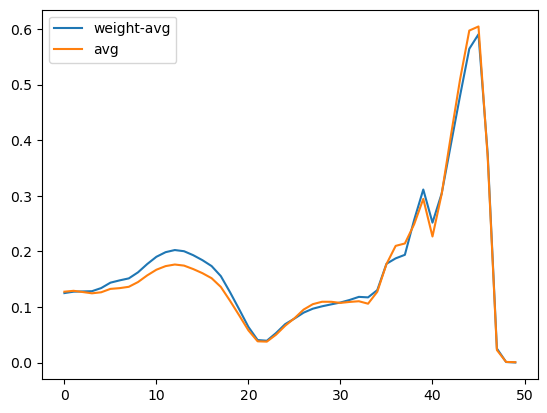

In [100]:
# testing plot r_sq with x without weighting:

r_sq_annual_5deg_wei = np.divide(np.nansum(r_sq_annual_5deg*weight_5deg_pct, axis=1),weight_5deg_sum)
r_sq_annual_5deg_avg = np.nanmean(r_sq_annual_5deg, axis=1)

print(r_sq_annual_5deg_wei.shape, r_sq_annual_5deg_avg.shape)
plt.plot(r_sq_annual_5deg_wei[:,1],label='weight-avg')
plt.plot(r_sq_annual_5deg_avg[:,1],label='avg')
plt.legend()


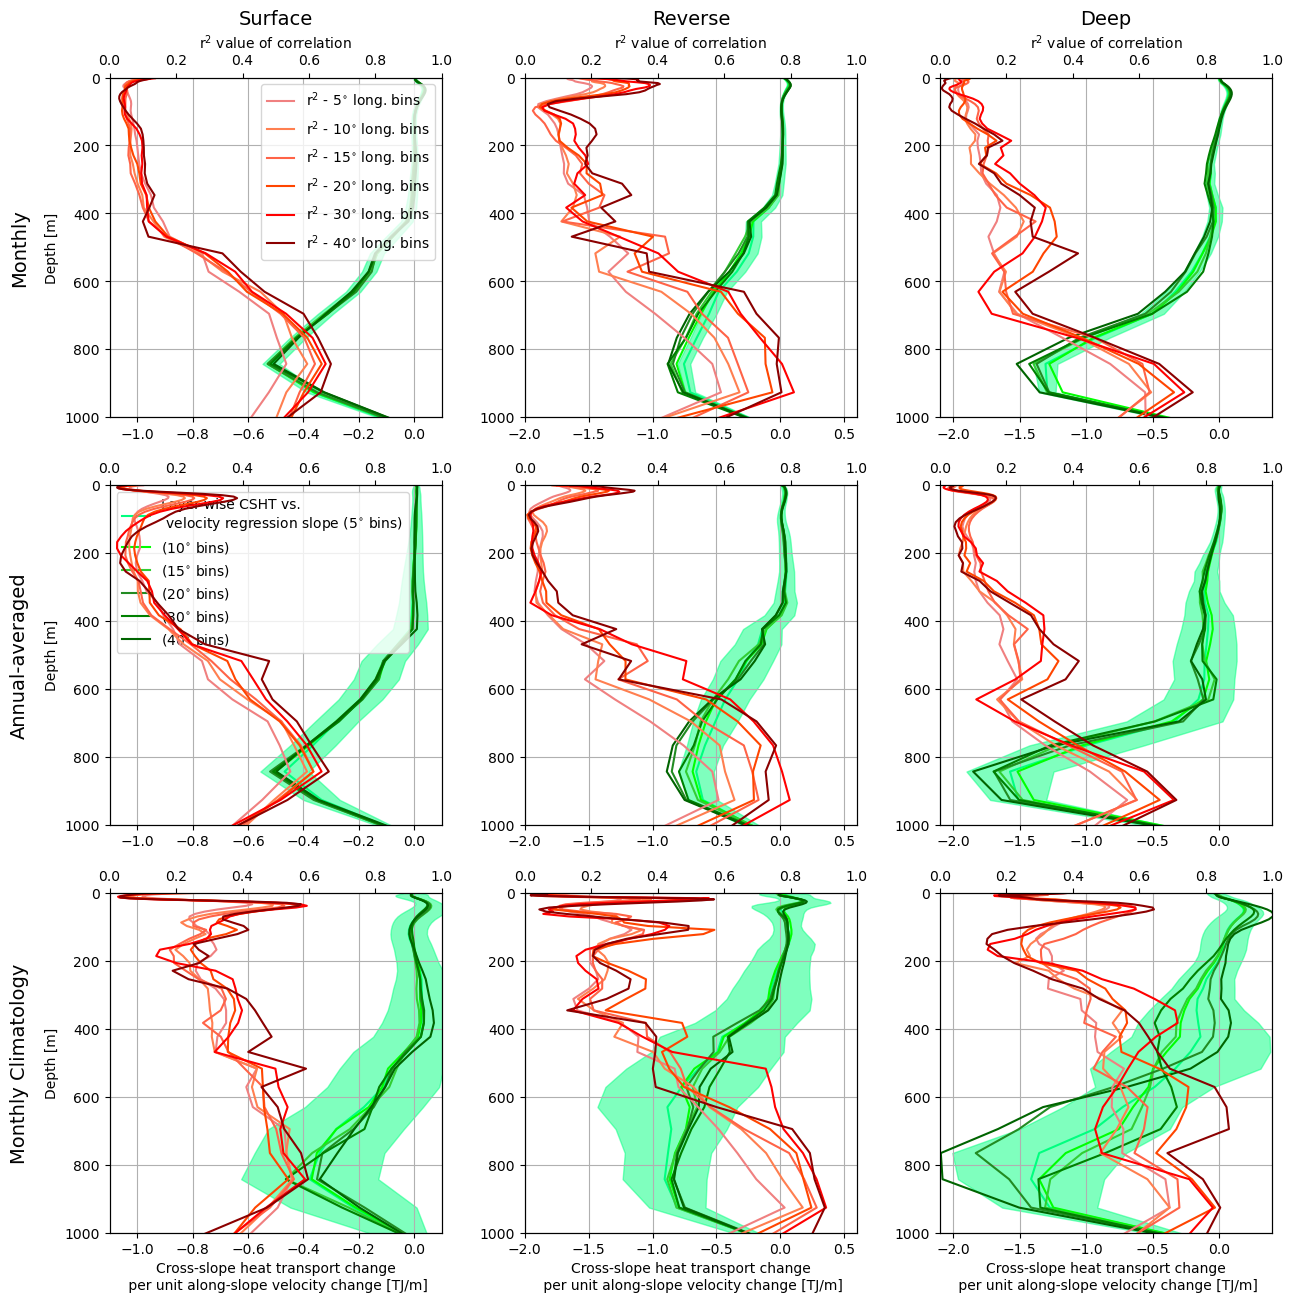

In [101]:
colors = ['skyblue', 'orange', 'purple']
values = [0, 1, 2]
classes = ['Surface', 'Reverse', 'Deep']
cmap = plt.cm.colors.ListedColormap(colors)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3):
    axs[i+3].plot(slope_annual_wavg_5deg[:,i], depth_5deg, color='springgreen', label = 'Layer-wise CSHT vs.\n velocity regression slope (5$^{\circ}$ bins)')
    axs[i+3].fill_betweenx( depth_5deg,  slope_annual_wavg_5deg[:,i]-stderr_annual_wavg_5deg[:,i]*2, slope_annual_wavg_5deg[:,i]+stderr_annual_wavg_5deg[:,i]*2, alpha=0.5, color='springgreen')
    axs[i+3].plot(slope_annual_wavg_10deg[:,i], depth_10deg, color='lime', linestyle='-', label = '(10$^{\circ}$ bins)')
    axs[i+3].plot(slope_annual_wavg_15deg[:,i], depth_15deg, color='limegreen', linestyle='-', label = '(15$^{\circ}$ bins)')

    axs[i+3].plot(slope_annual_wavg_20deg[:,i], depth_20deg, color='forestgreen', linestyle='-', label = '(20$^{\circ}$ bins)')
    axs[i+3].plot(slope_annual_wavg_30deg[:,i], depth_30deg, color='green', linestyle='-', label = '(30$^{\circ}$ bins)')
    axs[i+3].plot(slope_annual_wavg_40deg[:,i], depth_40deg, color='darkgreen', linestyle='-', label = '(40$^{\circ}$ bins)')

    if i==0:
        axs[i+3].legend()
    
    axs[i].plot(slope_all_wavg_5deg[:,i], depth_5deg, color='springgreen')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].fill_betweenx( depth_5deg,  slope_all_wavg_5deg[:,i]-stderr_all_wavg_5deg[:,i]*2, slope_all_wavg_5deg[:,i]+stderr_all_wavg_5deg[:,i]*2, alpha=0.5, color='springgreen')
    axs[i].plot(slope_all_wavg_10deg[:,i], depth_10deg, color='lime', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].plot(slope_all_wavg_15deg[:,i], depth_15deg, color='limegreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].plot(slope_all_wavg_20deg[:,i], depth_20deg, color='forestgreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].plot(slope_all_wavg_30deg[:,i], depth_30deg, color='green', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].plot(slope_all_wavg_40deg[:,i], depth_40deg, color='darkgreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')

    axs[i+6].plot(slope_clima_wavg_5deg[:,i], depth_5deg, color='springgreen')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].fill_betweenx(depth_5deg, slope_clima_wavg_5deg[:,i]-stderr_clima_wavg_5deg[:,i]*2, slope_clima_wavg_5deg[:,i]+stderr_clima_wavg_5deg[:,i]*2, alpha=0.5, color='springgreen')
    axs[i+6].plot(slope_clima_wavg_10deg[:,i], depth_10deg, color='lime', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].plot(slope_clima_wavg_15deg[:,i], depth_15deg, color='limegreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].plot(slope_clima_wavg_20deg[:,i], depth_20deg, color='forestgreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].plot(slope_clima_wavg_30deg[:,i], depth_30deg, color='green', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].plot(slope_clima_wavg_40deg[:,i], depth_40deg, color='darkgreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')

    axs[i].set_title(classes[i], fontsize=14)
    ax1 = axs[i].twiny()
    ax2 = axs[i+3].twiny()
    ax3 = axs[i+6].twiny()

    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    ax1.set_xlabel('r$^2$ value of correlation')
    ax1.plot(r_sq_annual_wavg_5deg[:,i], depth_5deg, color='lightcoral', label = 'r$^2$ - 5$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_wavg_10deg[:,i], depth_10deg, color='coral', label = 'r$^2$ - 10$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_wavg_15deg[:,i], depth_15deg, color='tomato', label = 'r$^2$ - 15$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_wavg_20deg[:,i], depth_20deg, color='orangered', label = 'r$^2$ - 20$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_wavg_30deg[:,i], depth_30deg, color='red', label = 'r$^2$ - 30$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_wavg_40deg[:,i], depth_40deg, color='darkred', label = 'r$^2$ - 40$^{\circ}$ long. bins')
    if i==0:
        ax1.legend()
    ax2.set_xlim(0,1)
    ax2.set_ylim(1000,0)
    ax2.plot(r_sq_all_wavg_5deg[:,i], depth_5deg, color='lightcoral', label = 'r$^2$ - 5$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_wavg_10deg[:,i], depth_10deg, color='coral', label = 'r$^2$ - 10$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_wavg_15deg[:,i], depth_15deg, color='tomato', label = 'r$^2$ - 15$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_wavg_20deg[:,i], depth_20deg, color='orangered', label = 'r$^2$ - 20$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_wavg_30deg[:,i], depth_30deg, color='red', label = 'r$^2$ - 30$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_wavg_40deg[:,i], depth_40deg, color='darkred', label = 'r$^2$ - 40$^{\circ}$ long. bins')
    ax3.set_xlim(0,1)
    ax3.set_ylim(1000,0)
    ax3.plot(r_sq_clima_wavg_5deg[:,i], depth_5deg, color='lightcoral')
    ax3.plot(r_sq_clima_wavg_10deg[:,i], depth_10deg, color='coral')
    ax3.plot(r_sq_clima_wavg_15deg[:,i], depth_15deg, color='tomato')
    ax3.plot(r_sq_clima_wavg_20deg[:,i], depth_20deg, color='orangered')
    ax3.plot(r_sq_clima_wavg_30deg[:,i], depth_30deg, color='red')
    ax3.plot(r_sq_clima_wavg_40deg[:,i], depth_40deg, color='darkred')

    axs[0].set_ylabel('Depth [m]')
    axs[3].set_ylabel('Depth [m]')
    axs[6].set_ylabel('Depth [m]')

    axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    axs[3*i].set_xlim(-1.1,0.1)
    axs[3*i+1].set_xlim(-2,0.6)
    axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+3].invert_yaxis()
    axs[i+3].set_ylim(1000,0)
    axs[i+3].grid()
    axs[i+6].invert_yaxis()
    axs[i+6].set_ylim(1000,0)
    axs[i+6].grid()

axs[0].text(-0.3,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.3,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

plt.savefig('/g/data/hh5/tmp/access-om/fbd581/ASC_project/ASC_and_heat_transport/figs/layer_wise_CSHT_vs_U_corr_BinsComparison_v2_wavg.png', bbox_inches='tight', dpi=300)
plt.show()

In [105]:
# old calcs below (without weighting)

In [102]:
depth4plot = depth_5deg

slope_annual_reg_5deg = np.nanmean(slope_annual_5deg, axis=1)
slope_all_reg_5deg = np.nanmean(slope_all_5deg, axis=1)
slope_clima_reg_5deg = np.nanmean(slope_clima_5deg, axis=1)

stderr_annual_reg_5deg = np.nanmean(stderr_annual_5deg, axis=1)
stderr_all_reg_5deg = np.nanmean(stderr_all_5deg, axis=1)
stderr_clima_reg_5deg = np.nanmean(stderr_clima_5deg, axis=1)

r_sq_annual_reg_5deg = np.nanmean(r_sq_annual_5deg, axis=1)
r_sq_all_reg_5deg = np.nanmean(r_sq_all_5deg, axis=1)
r_sq_clima_reg_5deg = np.nanmean(r_sq_clima_5deg, axis=1)

# average r^2 800 and bottom;

r_sq_annual_plot_5deg = np.nanmean(r_sq_annual_5deg[-7:,:,:], axis=0)
r_sq_all_plot_5deg = np.nanmean(r_sq_all_5deg[-7:,:,:], axis=0)
r_sq_clima_plot_5deg = np.nanmean(r_sq_clima_5deg[-7:,:,:], axis=0)

In [103]:
depth4plot = depth_10deg

slope_annual_reg_10deg = np.nanmean(slope_annual_10deg, axis=1)
slope_all_reg_10deg = np.nanmean(slope_all_10deg, axis=1)
slope_clima_reg_10deg = np.nanmean(slope_clima_10deg, axis=1)

stderr_annual_reg_10deg = np.nanmean(stderr_annual_10deg, axis=1)
stderr_all_reg_10deg = np.nanmean(stderr_all_10deg, axis=1)
stderr_clima_reg_10deg = np.nanmean(stderr_clima_10deg, axis=1)

r_sq_annual_reg_10deg = np.nanmean(r_sq_annual_10deg, axis=1)
r_sq_all_reg_10deg = np.nanmean(r_sq_all_10deg, axis=1)
r_sq_clima_reg_10deg = np.nanmean(r_sq_clima_10deg, axis=1)

# average r^2 800 and bottom;

r_sq_annual_plot_10deg = np.nanmean(r_sq_annual_10deg[-7:,:,:], axis=0)
r_sq_all_plot_10deg = np.nanmean(r_sq_all_10deg[-7:,:,:], axis=0)
r_sq_clima_plot_10deg = np.nanmean(r_sq_clima_10deg[-7:,:,:], axis=0)

In [104]:
## read these and then plot all together: 15deg

depth4plot = depth_15deg

slope_annual_reg_15deg = np.nanmean(slope_annual_15deg, axis=1)
slope_all_reg_15deg = np.nanmean(slope_all_15deg, axis=1)
slope_clima_reg_15deg = np.nanmean(slope_clima_15deg, axis=1)

stderr_annual_reg_15deg = np.nanmean(stderr_annual_15deg, axis=1)
stderr_all_reg_15deg = np.nanmean(stderr_all_15deg, axis=1)
stderr_clima_reg_15deg = np.nanmean(stderr_clima_15deg, axis=1)

r_sq_annual_reg_15deg = np.nanmean(r_sq_annual_15deg, axis=1)
r_sq_all_reg_15deg = np.nanmean(r_sq_all_15deg, axis=1)
r_sq_clima_reg_15deg = np.nanmean(r_sq_clima_15deg, axis=1)

# average r^2 800 and bottom;

r_sq_annual_plot_15deg = np.nanmean(r_sq_annual_15deg[-7:,:,:], axis=0)
r_sq_all_plot_15deg = np.nanmean(r_sq_all_15deg[-7:,:,:], axis=0)
r_sq_clima_plot_15deg = np.nanmean(r_sq_clima_15deg[-7:,:,:], axis=0)

In [105]:
depth4plot = depth_20deg

slope_annual_reg_20deg = np.nanmean(slope_annual_20deg, axis=1)
slope_all_reg_20deg = np.nanmean(slope_all_20deg, axis=1)
slope_clima_reg_20deg = np.nanmean(slope_clima_20deg, axis=1)

stderr_annual_reg_20deg = np.nanmean(stderr_annual_20deg, axis=1)
stderr_all_reg_20deg = np.nanmean(stderr_all_20deg, axis=1)
stderr_clima_reg_20deg = np.nanmean(stderr_clima_20deg, axis=1)

r_sq_annual_reg_20deg = np.nanmean(r_sq_annual_20deg, axis=1)
r_sq_all_reg_20deg = np.nanmean(r_sq_all_20deg, axis=1)
r_sq_clima_reg_20deg = np.nanmean(r_sq_clima_20deg, axis=1)

# average r^2 800 and bottom;

r_sq_annual_plot_20deg = np.nanmean(r_sq_annual_20deg[-7:,:,:], axis=0)
r_sq_all_plot_20deg = np.nanmean(r_sq_all_20deg[-7:,:,:], axis=0)
r_sq_clima_plot_20deg = np.nanmean(r_sq_clima_20deg[-7:,:,:], axis=0)

In [106]:
depth4plot = depth_30deg

slope_annual_reg_30deg = np.nanmean(slope_annual_30deg, axis=1)
slope_all_reg_30deg = np.nanmean(slope_all_30deg, axis=1)
slope_clima_reg_30deg = np.nanmean(slope_clima_30deg, axis=1)

stderr_annual_reg_30deg = np.nanmean(stderr_annual_30deg, axis=1)
stderr_all_reg_30deg = np.nanmean(stderr_all_30deg, axis=1)
stderr_clima_reg_30deg = np.nanmean(stderr_clima_30deg, axis=1)

r_sq_annual_reg_30deg = np.nanmean(r_sq_annual_30deg, axis=1)
r_sq_all_reg_30deg = np.nanmean(r_sq_all_30deg, axis=1)
r_sq_clima_reg_30deg = np.nanmean(r_sq_clima_30deg, axis=1)

# average r^2 800 and bottom;

r_sq_annual_plot_30deg = np.nanmean(r_sq_annual_30deg[-7:,:,:], axis=0)
r_sq_all_plot_30deg = np.nanmean(r_sq_all_30deg[-7:,:,:], axis=0)
r_sq_clima_plot_30deg = np.nanmean(r_sq_clima_30deg[-7:,:,:], axis=0)

In [107]:
depth4plot = depth_40deg

slope_annual_reg_40deg = np.nanmean(slope_annual_40deg, axis=1)
slope_all_reg_40deg = np.nanmean(slope_all_40deg, axis=1)
slope_clima_reg_40deg = np.nanmean(slope_clima_40deg, axis=1)

stderr_annual_reg_40deg = np.nanmean(stderr_annual_40deg, axis=1)
stderr_all_reg_40deg = np.nanmean(stderr_all_40deg, axis=1)
stderr_clima_reg_40deg = np.nanmean(stderr_clima_40deg, axis=1)

r_sq_annual_reg_40deg = np.nanmean(r_sq_annual_40deg, axis=1)
r_sq_all_reg_40deg = np.nanmean(r_sq_all_40deg, axis=1)
r_sq_clima_reg_40deg = np.nanmean(r_sq_clima_40deg, axis=1)

# average r^2 800 and bottom;

r_sq_annual_plot_40deg = np.nanmean(r_sq_annual_40deg[-7:,:,:], axis=0)
r_sq_all_plot_40deg = np.nanmean(r_sq_all_40deg[-7:,:,:], axis=0)
r_sq_clima_plot_40deg = np.nanmean(r_sq_clima_40deg[-7:,:,:], axis=0)

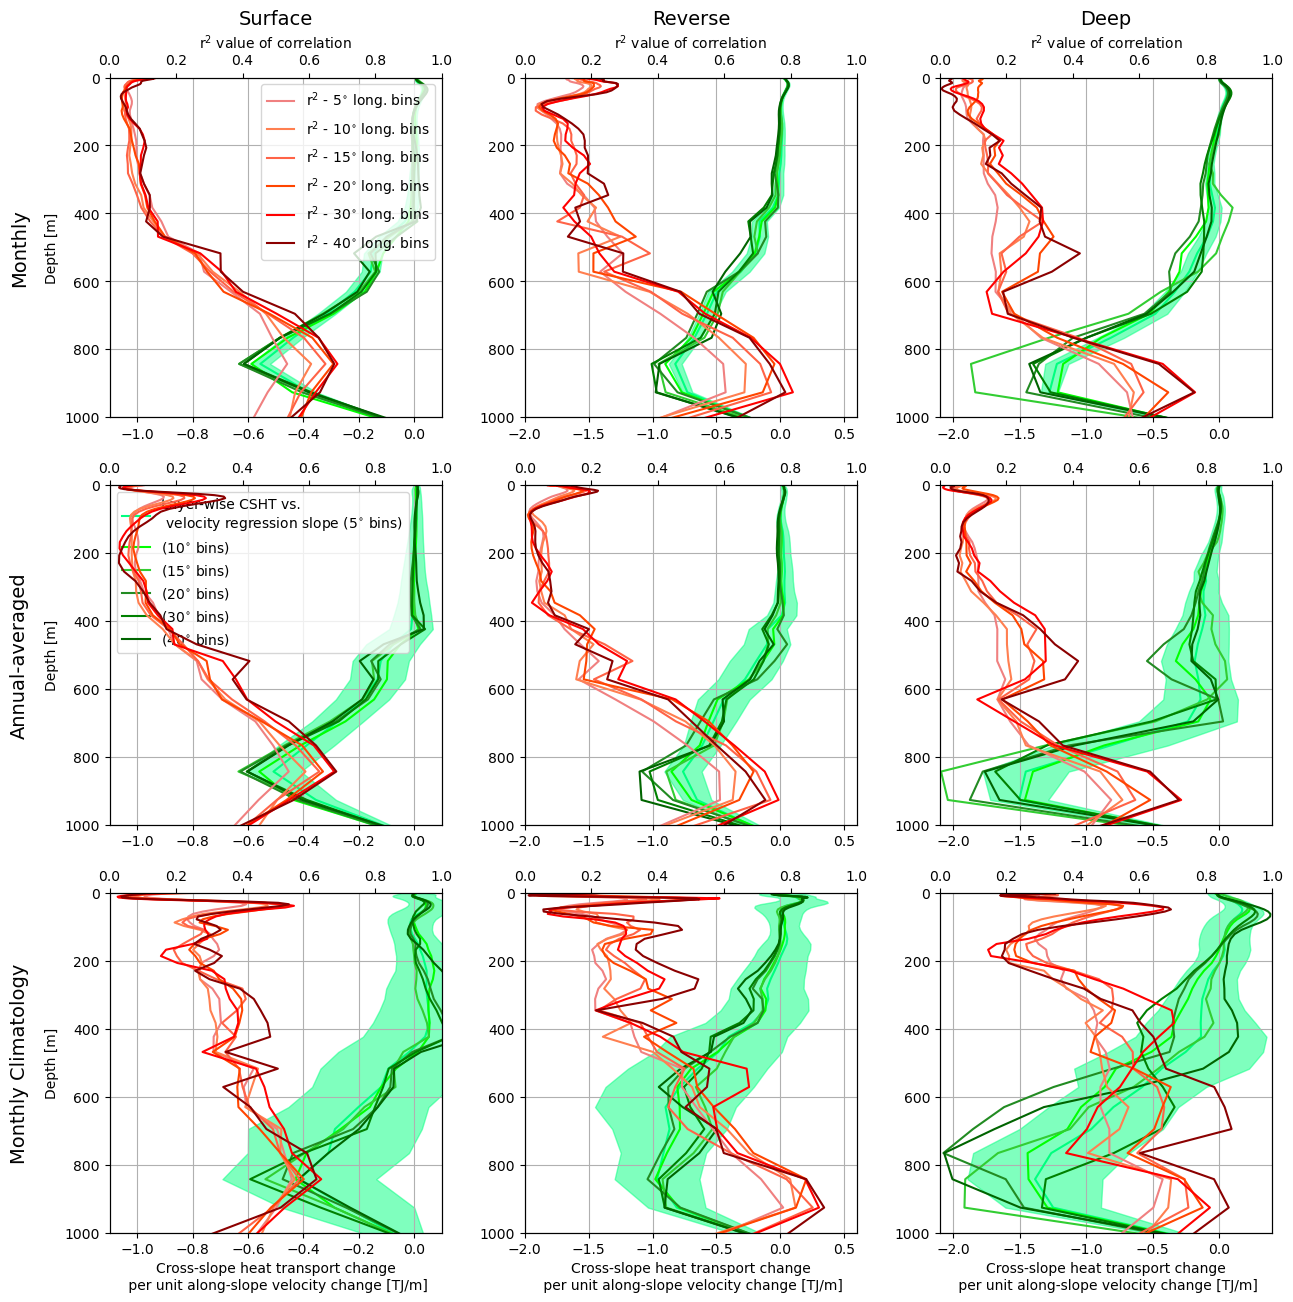

In [109]:
colors = ['skyblue', 'orange', 'purple']
values = [0, 1, 2]
classes = ['Surface', 'Reverse', 'Deep']
cmap = plt.cm.colors.ListedColormap(colors)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3):
    axs[i+3].plot(slope_annual_reg_5deg[:,i], depth_5deg, color='springgreen', label = 'Layer-wise CSHT vs.\n velocity regression slope (5$^{\circ}$ bins)')
    axs[i+3].fill_betweenx( depth_5deg,  slope_annual_reg_5deg[:,i]-stderr_annual_reg_5deg[:,i]*2, slope_annual_reg_5deg[:,i]+stderr_annual_reg_5deg[:,i]*2, alpha=0.5, color='springgreen')
    axs[i+3].plot(slope_annual_reg_10deg[:,i], depth_10deg, color='lime', linestyle='-', label = '(10$^{\circ}$ bins)')
    axs[i+3].plot(slope_annual_reg_15deg[:,i], depth_15deg, color='limegreen', linestyle='-', label = '(15$^{\circ}$ bins)')

    axs[i+3].plot(slope_annual_reg_20deg[:,i], depth_20deg, color='forestgreen', linestyle='-', label = '(20$^{\circ}$ bins)')
    axs[i+3].plot(slope_annual_reg_30deg[:,i], depth_30deg, color='green', linestyle='-', label = '(30$^{\circ}$ bins)')
    axs[i+3].plot(slope_annual_reg_40deg[:,i], depth_40deg, color='darkgreen', linestyle='-', label = '(40$^{\circ}$ bins)')

    if i==0:
        axs[i+3].legend()
    
    axs[i].plot(slope_all_reg_5deg[:,i], depth_5deg, color='springgreen')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].fill_betweenx( depth_5deg,  slope_all_reg_5deg[:,i]-stderr_all_reg_5deg[:,i]*2, slope_all_reg_5deg[:,i]+stderr_all_reg_5deg[:,i]*2, alpha=0.5, color='springgreen')
    axs[i].plot(slope_all_reg_10deg[:,i], depth_10deg, color='lime', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].plot(slope_all_reg_15deg[:,i], depth_15deg, color='limegreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].plot(slope_all_reg_20deg[:,i], depth_20deg, color='forestgreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].plot(slope_all_reg_30deg[:,i], depth_30deg, color='green', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].plot(slope_all_reg_40deg[:,i], depth_40deg, color='darkgreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')

    axs[i+6].plot(slope_clima_reg_5deg[:,i], depth_5deg, color='springgreen')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].fill_betweenx(depth_5deg, slope_clima_reg_5deg[:,i]-stderr_clima_reg_5deg[:,i]*2, slope_clima_reg_5deg[:,i]+stderr_clima_reg_5deg[:,i]*2, alpha=0.5, color='springgreen')
    axs[i+6].plot(slope_clima_reg_10deg[:,i], depth_10deg, color='lime', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].plot(slope_clima_reg_15deg[:,i], depth_15deg, color='limegreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].plot(slope_clima_reg_20deg[:,i], depth_20deg, color='forestgreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].plot(slope_clima_reg_30deg[:,i], depth_30deg, color='green', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].plot(slope_clima_reg_40deg[:,i], depth_40deg, color='darkgreen', linestyle='-')#, label = 'Layer-wise CSHT vs.\n velocity regression slope')

    axs[i].set_title(classes[i], fontsize=14)
    ax1 = axs[i].twiny()
    ax2 = axs[i+3].twiny()
    ax3 = axs[i+6].twiny()

    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    ax1.set_xlabel('r$^2$ value of correlation')
    ax1.plot(r_sq_annual_reg_5deg[:,i], depth_5deg, color='lightcoral', label = 'r$^2$ - 5$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_reg_10deg[:,i], depth_10deg, color='coral', label = 'r$^2$ - 10$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_reg_15deg[:,i], depth_15deg, color='tomato', label = 'r$^2$ - 15$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_reg_20deg[:,i], depth_20deg, color='orangered', label = 'r$^2$ - 20$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_reg_30deg[:,i], depth_30deg, color='red', label = 'r$^2$ - 30$^{\circ}$ long. bins')
    ax1.plot(r_sq_annual_reg_40deg[:,i], depth_40deg, color='darkred', label = 'r$^2$ - 40$^{\circ}$ long. bins')
    if i==0:
        ax1.legend()
    ax2.set_xlim(0,1)
    ax2.set_ylim(1000,0)
    ax2.plot(r_sq_all_reg_5deg[:,i], depth_5deg, color='lightcoral', label = 'r$^2$ - 5$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_reg_10deg[:,i], depth_10deg, color='coral', label = 'r$^2$ - 10$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_reg_15deg[:,i], depth_15deg, color='tomato', label = 'r$^2$ - 15$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_reg_20deg[:,i], depth_20deg, color='orangered', label = 'r$^2$ - 20$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_reg_30deg[:,i], depth_30deg, color='red', label = 'r$^2$ - 30$^{\circ}$ long. bins')
    ax2.plot(r_sq_all_reg_40deg[:,i], depth_40deg, color='darkred', label = 'r$^2$ - 40$^{\circ}$ long. bins')
    ax3.set_xlim(0,1)
    ax3.set_ylim(1000,0)
    ax3.plot(r_sq_clima_reg_5deg[:,i], depth_5deg, color='lightcoral')
    ax3.plot(r_sq_clima_reg_10deg[:,i], depth_10deg, color='coral')
    ax3.plot(r_sq_clima_reg_15deg[:,i], depth_15deg, color='tomato')
    ax3.plot(r_sq_clima_reg_20deg[:,i], depth_20deg, color='orangered')
    ax3.plot(r_sq_clima_reg_30deg[:,i], depth_30deg, color='red')
    ax3.plot(r_sq_clima_reg_40deg[:,i], depth_40deg, color='darkred')

    axs[0].set_ylabel('Depth [m]')
    axs[3].set_ylabel('Depth [m]')
    axs[6].set_ylabel('Depth [m]')

    axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    axs[3*i].set_xlim(-1.1,0.1)
    axs[3*i+1].set_xlim(-2,0.6)
    axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+3].invert_yaxis()
    axs[i+3].set_ylim(1000,0)
    axs[i+3].grid()
    axs[i+6].invert_yaxis()
    axs[i+6].set_ylim(1000,0)
    axs[i+6].grid()

axs[0].text(-0.3,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.3,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

plt.savefig('/g/data/hh5/tmp/access-om/fbd581/ASC_project/ASC_and_heat_transport/figs/layer_wise_CSHT_vs_U_corr_BinsComparison_v2_avg.png', bbox_inches='tight', dpi=300)
plt.show()